# Import Module

In [57]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof
import random

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

# Settings

### Variables

In [58]:
variables = ['tas']
variable = 'tas'
TITLE = 'Surface Temperature'
ylabel = '$E_{tas}$ ($K$)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/CNRMppe_error_decomposition/files/'
path_file_npy = '/data/home/globc/peatier/CNRMppe_save/PPE/ENSEMBLE2/files/npy/'

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [5]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

In [59]:
def MSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = (diff_tmp.sum(['lat', 'lon']))
    return diff

In [60]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [61]:
def MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = MSE(mod, obs, W_rmse_2D)
    return diff

In [62]:
def MultiLinReg_pred(LHS, X ,y, param_names) :

    LHS_df = pd.DataFrame(LHS)

    lhs = LHS_df.values
    #LHS_df

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    N=len(LHS_df.values)
    tmp = [0]*N
    y_pred = [0]*N
    i=0
    Ycpt=0
    while i<N:
        
        tmp[i] = Coeffs.values*LHS_df.iloc[i]
        y_pred[i] = tmp[i].sum()+R
        i+=1

    #y_pred
    #members = arange(102,100102,1)
    #DFYpred = pd.DataFrame([y_pred, members], index=["y_pred", "members"]).transpose()
    return y_pred

# Get data 

In [10]:
path_file = path_files+'npy/'
filename = 'CNRMppe_decomposition_mean_'+str(variable)+'.npy'
Mean =  pd.read_pickle(path_file+filename).to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})

In [11]:
W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(variable)+'.npy')
W_eof_3D = np.load(path_files+'npy/W_eof_3D_'+str(variable)+'.npy')
W_rmse_2D = np.load(path_files+'npy/W_rmse_2D_'+str(variable)+'.npy')

### BEST observations

In [12]:
path_observation = '/data/scratch/globc/peatier/obs_data/BEST/'
filename = 'Land_and_Ocean_LatLong1_regrid_1979-1981.nc'

In [13]:
# POUR LES OBSERVATIONS BEST

path = path_observation

file =  xr.open_mfdataset(path+filename,combine='by_coords')
clim = file['climatology'].to_dataframe()#.drop(columns='month_number')
clim = pd.concat([clim, clim, clim]).reset_index('month_number')

df_obs=file['temperature'].to_dataframe().reset_index('time')
df_obs['temperature'] = df_obs['temperature']
df_obs['clim'] = clim['climatology']
df_obs['ta'] = df_obs['temperature']+df_obs['clim']+273.15
variable_obs = 'ta'

In [14]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()

In [15]:
## --Observations
X_obs = obs[variable_obs] - Mean
X_obs_w = X_obs*W_eof_2D

### PPE simulations 

In [16]:
## --Get the pc_PPE
path_file = path_files+'nc/'
filename = 'CNRMppe_decomposition_EOFpc_'+str(variable)+'.nc'
pc_PPE = xr.open_dataset(path_file+filename)
pc_PPE['pcs'][:, 0:18]

<xarray.DataArray 'pcs' (time: 102, mode: 18)>
array([[-1.037732, -1.772081,  0.099338, ..., -1.388161, -0.359571, -0.372029],
       [ 0.500078,  0.633004, -0.643879, ...,  0.838493,  1.096848,  0.678603],
       [ 1.53893 , -0.967792,  0.19294 , ..., -0.251735, -1.386534,  1.106333],
       ...,
       [-0.200386,  1.630405, -0.603054, ..., -0.478073,  0.141957,  0.949141],
       [ 1.692824,  0.389283, -1.014095, ..., -0.210852,  0.058477, -0.518042],
       [ 0.933678,  1.233882,  0.656814, ...,  1.102929, -0.371502, -2.79235 ]])
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 ... 94 95 96 97 98 99 100 101 102
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17

### Reference simulation p1

In [17]:
# Reference simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_tas_xarr(path, filename, variables)

In [18]:
## --Full error e(\theta_0)
mod = p1_amip
observation = obs[variable_obs]
diff_p1 = RMSE(mod, observation, W_rmse_2D)

In [19]:
diff_p1.values

array(1.41886474)

In [20]:
## --Anom and weight
X_p1 = p1_amip - Mean
X_p1_w = X_p1*W_eof_2D

# EOF Solver

In [21]:
# PPE amip simulations 
filename='*_amip_*.nc'
N=len(nb_p_list)
amip={}

i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_tas_xarr(path, filename, variables)
    i=i+1

In [22]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

amip_list[0] = p1_amip

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    amip_list[i+1] = tmp
    i+=1

In [23]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])

In [24]:
## --PPE simulations
mean = matrix.mean(axis=0)
anom = matrix - mean
anom_w = (anom*W_eof_3D)

In [25]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom_w, center=False, weights=None)

# Emulations 100 000

In [67]:
path = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy"
LHS = np.load(file=path+"/LHS100000_param_standard.npy")
X = np.load(file=path+"/X_EmulateurFeedbacksN.npy")
param_names = np.load(file=path+"/LHS_paramNames.npy")


pc_pred = []

for i in range(0,18,1) :
    #print(i)
    y = pc_PPE['pcs'][:, i]
    tmp = MultiLinReg_pred(LHS, X ,y, param_names)
    pc_pred.append(tmp)
#pc_pred

In [68]:
df_pc_pred = pd.DataFrame(pc_pred[0], columns= ['EOF 1'])
for i in range(1,18,1) :
    ind = 'EOF '+str(i+1)
    df_pc_pred[ind] = pc_pred[i]
df_pc_pred

EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6     EOF 7  \
0      0.053160  0.591416  0.177104  0.866376  0.718467  0.659540 -0.043037   
1     -0.259237  0.647073 -0.452515  1.409053  0.870643  0.667772 -1.261793   
2     -0.050450  0.146491 -1.425103 -0.870566 -0.249998 -0.354165 -0.285270   
3      1.133615 -1.250214 -1.322137  1.910634  1.905300  0.142851 -0.127473   
4     -0.657846 -0.100945  2.477285 -0.208477 -0.485037 -0.204115 -0.430936   
...         ...       ...       ...       ...       ...       ...       ...   
99995 -0.349083  0.723257 -0.359346 -0.372656 -1.266572 -0.090595 -0.046930   
99996  0.925938  0.211934 -0.261631  0.588695 -0.560485  0.142986 -1.146804   
99997 -1.077140  0.734859 -1.400953 -0.835652  0.436109  1.047429  1.265766   
99998  1.019538  1.927900 -0.051013  0.596887  0.884314  0.370158  1.676687   
99999  0.215085 -0.876168  0.095835 -1.244400  1.377519  0.435242  0.023417   

          EOF 8     EOF 9    EOF 10    EOF 11    EOF 12    EOF 13    EOF 14  \
0      0.556143  0.368303 -1.033655  0.433413  1.109543  0.321661  1.513375   
1     -0.218841 -0.226251 -0.316316 -0.687209 -0.269193  0.721731  1.066529   
2     -1.353141  0.577560 -0.725585  0.106225  1.624095  0.920702  1.138463   
3      0.419342  0.802691  0.352713 -0.373750 -0.253786 -0.894195 -0.389659   
4     -0.878425  0.267369 -0.884294  0.385899  1.002614  0.633993  1.667335   
...         ...       ...       ...       ...       ...       ...       ...   
99995  1.096434 -0.197282  0.595198  0.487233 -0.167956  0.384730  0.210671   
99996 -0.050800 -1.661729 -0.765650  0.510150 -0.411819  0.997161  1.464526   
99997 -0.080022 -0.185519 -1.106912  0.543456  0.662341  0.186721 -1.133502   
99998 -0.526902 -1.004441  1.178439 -0.590084 -0.446860  0.399176 -0.833858   
99999  0.754573  0.550383 -0.200962 -0.853963 -1.462664 -1.414264  0.910493   

         EOF 15    EOF 16    EOF 17    EOF 18  
0      0.452024 -0.274895 -0.594091  0.293428  
1     -0.923241  1.317171  0.553031 -0.158446  
2      1.913375 -1.009275  0.666004 -0.200700  
3     -0.691261  0.796069  0.045508  0.170146  
4      0.034571 -0.438587 -0.113232 -0.295158  
...         ...       ...       ...       ...  
99995  0.576769  0.693359 -0.089323 -0.049016  
99996  0.167511 -0.170063 -0.466461 -0.072847  
99997  0.661931  0.041753  0.986693 -0.312779  
99998  0.340601 -0.714119 -0.727947 -0.473892  
99999 -0.592440  1.195323 -1.538610 -0.827962  

[100000 rows x 18 columns]

# Calcule RMSE reconstructed (p)

In [26]:
eofs=[]
for j in range(1, 19, 1) :
    ## --Get the eofs
    eof_tmp = pd.read_pickle(path_files+"npy/CNRMppe_decomposition_EOFmap"+str(j)+"_"+str(variable)+".npy").to_xarray().to_array()
    eof_tmp = eof_tmp[0,:,:].rename({'variable':'mode'})
    eofs.append(eof_tmp)

## --Combine the modes for reconstruction
eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')

In [27]:
## --Project and reconstruct the observations
U_obs = solver.projectField(X_obs_w, neofs=18, weighted=False, eofscaling=1)
X_obs_rec = reconstruct_X(eofs_combined, pc=U_obs, nb_dims=2)

In [63]:
## --Project and reconstruct p1
U_p1 = solver.projectField(X_p1_w, neofs=18, weighted=False, eofscaling=1)
X_p1_rec = reconstruct_X(eofs_combined, pc=U_p1, nb_dims=2)

## --Param. error p(\theta_0)
p_p1 = MSE_rec(X_p1_rec, X_obs_rec, Mean, W_rmse_2D)

In [64]:
p_p1

<xarray.DataArray ()>
array(1.05263181)

In [69]:
nb_dims = 2
p_pred = []
for i in range(0,100000,1) : 
    pc = df_pc_pred.iloc[i]
    X_mod_rec = reconstruct_X(eofs_combined, pc, nb_dims)
    tmp = MSE_rec(X_mod_rec, X_obs_rec, Mean, W_rmse_2D)
    p_pred.append(float(tmp))
df_pc_pred['p'] = p_pred
df_pc_pred

EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6     EOF 7  \
0      0.053160  0.591416  0.177104  0.866376  0.718467  0.659540 -0.043037   
1     -0.259237  0.647073 -0.452515  1.409053  0.870643  0.667772 -1.261793   
2     -0.050450  0.146491 -1.425103 -0.870566 -0.249998 -0.354165 -0.285270   
3      1.133615 -1.250214 -1.322137  1.910634  1.905300  0.142851 -0.127473   
4     -0.657846 -0.100945  2.477285 -0.208477 -0.485037 -0.204115 -0.430936   
...         ...       ...       ...       ...       ...       ...       ...   
99995 -0.349083  0.723257 -0.359346 -0.372656 -1.266572 -0.090595 -0.046930   
99996  0.925938  0.211934 -0.261631  0.588695 -0.560485  0.142986 -1.146804   
99997 -1.077140  0.734859 -1.400953 -0.835652  0.436109  1.047429  1.265766   
99998  1.019538  1.927900 -0.051013  0.596887  0.884314  0.370158  1.676687   
99999  0.215085 -0.876168  0.095835 -1.244400  1.377519  0.435242  0.023417   

          EOF 8     EOF 9    EOF 10    EOF 11    EOF 12    EOF 13    EOF 14  \
0      0.556143  0.368303 -1.033655  0.433413  1.109543  0.321661  1.513375   
1     -0.218841 -0.226251 -0.316316 -0.687209 -0.269193  0.721731  1.066529   
2     -1.353141  0.577560 -0.725585  0.106225  1.624095  0.920702  1.138463   
3      0.419342  0.802691  0.352713 -0.373750 -0.253786 -0.894195 -0.389659   
4     -0.878425  0.267369 -0.884294  0.385899  1.002614  0.633993  1.667335   
...         ...       ...       ...       ...       ...       ...       ...   
99995  1.096434 -0.197282  0.595198  0.487233 -0.167956  0.384730  0.210671   
99996 -0.050800 -1.661729 -0.765650  0.510150 -0.411819  0.997161  1.464526   
99997 -0.080022 -0.185519 -1.106912  0.543456  0.662341  0.186721 -1.133502   
99998 -0.526902 -1.004441  1.178439 -0.590084 -0.446860  0.399176 -0.833858   
99999  0.754573  0.550383 -0.200962 -0.853963 -1.462664 -1.414264  0.910493   

         EOF 15    EOF 16    EOF 17    EOF 18         p  
0      0.452024 -0.274895 -0.594091  0.293428  1.036283  
1     -0.923241  1.317171  0.553031 -0.158446  1.100781  
2      1.913375 -1.009275  0.666004 -0.200700  1.389311  
3     -0.691261  0.796069  0.045508  0.170146  2.314204  
4      0.034571 -0.438587 -0.113232 -0.295158  0.807454  
...         ...       ...       ...       ...       ...  
99995  0.576769  0.693359 -0.089323 -0.049016  1.127336  
99996  0.167511 -0.170063 -0.466461 -0.072847  2.075135  
99997  0.661931  0.041753  0.986693 -0.312779  1.370659  
99998  0.340601 -0.714119 -0.727947 -0.473892  2.490433  
99999 -0.592440  1.195323 -1.538610 -0.827962  0.958970  

[100000 rows x 19 columns]

In [70]:
## --Save 
np.save(path_files+'npy/df_pc_pred.npy', df_pc_pred.values)

# ---------- Just to select candidates -------------

## Selection lower than ref

In [71]:
cpt_drop=[]
cpt=0
for i in p_pred : 
    if i>p_p1 : 
        cpt_drop.append(cpt)
        cpt+=1
    else :
        cpt+=1

In [35]:
df_pc_best = df_pc_pred.copy()
df_pc_best = df_pc_best.drop(cpt_drop)
df_pc_best = df_pc_best.reset_index()
df_pc_best

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6  \
0          0  0.053160  0.591416  0.177104  0.866376  0.718467  0.659540   
1          4 -0.657846 -0.100945  2.477285 -0.208477 -0.485037 -0.204115   
2          5 -1.469691 -0.875863  1.867064  0.317734  0.117693 -0.040501   
3          7 -0.680900 -1.489689 -0.527394  1.221240  0.160196 -0.208807   
4          8  0.272092 -0.762280  1.690819 -1.126358  0.707616 -1.384625   
...      ...       ...       ...       ...       ...       ...       ...   
27039  99988 -0.098217  0.735165  0.579784 -0.356114 -0.113721 -0.339570   
27040  99989 -0.149039 -0.725431  0.610171 -0.045447 -0.002070 -0.256868   
27041  99990  0.260802 -0.619722  1.692303  0.659605  0.656065  0.420272   
27042  99994  0.143116 -0.908388  0.486532  0.129072 -0.657171 -0.388476   
27043  99999  0.215085 -0.876168  0.095835 -1.244400  1.377519  0.435242   

          EOF 7     EOF 8     EOF 9    EOF 10    EOF 11    EOF 12    EOF 13  \
0     -0.043037  0.556143  0.368303 -1.033655  0.433413  1.109543  0.321661   
1     -0.430936 -0.878425  0.267369 -0.884294  0.385899  1.002614  0.633993   
2      0.693874 -0.572920  0.494804 -0.681906 -0.965773 -0.335608 -0.420781   
3     -1.040138  0.537645 -1.246970  0.123964 -0.249919 -0.070425  0.553692   
4     -1.228677 -1.250914  0.390563  1.171335  0.627476 -1.795416 -1.621383   
...         ...       ...       ...       ...       ...       ...       ...   
27039  0.282826  0.587459  0.728209 -0.162594 -0.135067 -0.845899  0.242420   
27040  0.127133  1.105932  0.464851 -0.849792  0.272097  0.785348  0.092108   
27041  1.021974 -0.146405  0.256291 -0.410115  1.157031  0.030986 -1.149404   
27042 -0.295390 -0.084206 -0.310382  1.312090 -0.336693 -0.187981 -0.483243   
27043  0.023417  0.754573  0.550383 -0.200962 -0.853963 -1.462664 -1.414264   

         EOF 14    EOF 15    EOF 16    EOF 17    EOF 18         p  
0      1.513375  0.452024 -0.274895 -0.594091  0.293428  1.017980  
1      1.667335  0.034571 -0.438587 -0.113232 -0.295158  0.898584  
2     -0.830582 -0.770455 -0.512789  0.183500 -0.401789  0.985553  
3      0.984406 -0.090978 -0.765705  1.268793  0.568358  0.956223  
4     -1.177933 -0.507719 -0.073077  0.019042 -0.074647  0.960588  
...         ...       ...       ...       ...       ...       ...  
27039  0.680693 -0.674629 -0.947839 -1.431510 -0.483259  0.961969  
27040  1.290776  1.655335  1.314124 -0.300648  0.383312  0.867153  
27041 -0.878397  1.373247  0.333861  0.346994 -0.324414  0.974024  
27042  0.600136 -1.563444  0.047186 -0.411098  0.254532  1.006810  
27043  0.910493 -0.592440  1.195323 -1.538610 -0.827962  0.979270  

[27044 rows x 20 columns]

In [36]:
## -- save
np.save(path_files+'npy/df_pc_low.npy', df_pc_best.values)

## Compute distances and drop near-neighbors

In [40]:
def Drop_candidates(df_pc_best, k) :
    ## -- Shuffle the data :
    df_pc_best_shuffle = df_pc_best.sample(frac=1).reset_index().drop('level_0', axis=1)
    
    ## -- Compute inter-point distances :
    nb_dims = 2
    d_list = []
    ind1_list = []
    ind2_list = []
    for i in range(0,int(len(df_pc_best)-1),2) : 
        #print(i)
        pc1 = df_pc_best_shuffle.iloc[i][1:-1]
        pc2 = df_pc_best_shuffle.iloc[i+1][1:-1]
    
        X_pc1 = reconstruct_X(eofs_combined, pc1, nb_dims)
        X_pc2 = reconstruct_X(eofs_combined, pc2, nb_dims)
    
        tmp = RMSE_rec(X_pc1, X_pc2, Mean, W_rmse_2D)
        d_list.append(float(tmp))
        ind1_list.append(i)
        ind2_list.append(i+1)
        
    ## -- Sort distances and select index to drop :
    df_d = pd.DataFrame(d_list, columns=['d'])
    df_d['ind1'] = ind1_list
    df_d['ind2'] = ind2_list
    df_d_sorted = df_d.sort_values(by='d')
    print(df_d_sorted)
    ind_drop = []
    for i in range(0, 200, 1) :
        ind_drop_tmp = random.choice([df_d_sorted['ind1'].iloc[i], df_d_sorted['ind2'].iloc[i]])
        print(df_d_sorted['ind1'].iloc[i], df_d_sorted['ind2'].iloc[i])
        print(ind_drop_tmp)
        ind_drop.append(ind_drop_tmp)
    print(ind_drop)
    ## -- Drop candidate : 
    df_pc_best_tmp = df_pc_best_shuffle.drop(ind_drop)
    
    ## -- Return DataFrame - 1 candidates : 
    return df_pc_best_tmp

In [41]:
k=5
cpt=0
while len(df_pc_best) > k :
    df_pc_best = Drop_candidates(df_pc_best, k)
    cpt+=1
    print(cpt)
#df_pc_best

              d   ind1   ind2
10962  0.172484  21924  21925
728    0.219640   1456   1457
12102  0.219862  24204  24205
2493   0.229466   4986   4987
7536   0.230213  15072  15073
...         ...    ...    ...
5976   1.380077  11952  11953
9946   1.389446  19892  19893
734    1.391622   1468   1469
11965  1.397421  23930  23931
2265   1.404704   4530   4531

[13422 rows x 3 columns]
21924 21925
21924
1456 1457
1457
24204 24205
24205
4986 4987
4986
15072 15073
15072
1554 1555
1555
13980 13981
13981
6034 6035
6035
9598 9599
9598
13252 13253
13253
2526 2527
2527
21272 21273
21273
15380 15381
15380
3862 3863
3862
20618 20619
20618
17614 17615
17615
19994 19995
19994
10280 10281
10280
16286 16287
16286
2844 2845
2845
6728 6729
6729
19764 19765
19764
476 477
477
1274 1275
1274
26394 26395
26395
1944 1945
1944
20980 20981
20980
6654 6655
6655
8254 8255
8255
9540 9541
9541
22630 22631
22631
1756 1757
1756
1492 1493
1492
8604 8605
8604
10918 10919
10918
12780 12781
12781
2978 2979
2978
4020 402

              d   ind1   ind2
5604   0.181728  11208  11209
6457   0.183622  12914  12915
3395   0.194529   6790   6791
9506   0.202943  19012  19013
2533   0.211690   5066   5067
...         ...    ...    ...
6105   1.387023  12210  12211
9525   1.389712  19050  19051
11373  1.396033  22746  22747
8078   1.420060  16156  16157
2790   1.446475   5580   5581

[13222 rows x 3 columns]
11208 11209
11209
12914 12915
12914
6790 6791
6791
19012 19013
19013
5066 5067
5066
20610 20611
20611
10908 10909
10908
16412 16413
16412
21456 21457
21457
15560 15561
15561
25816 25817
25816
7806 7807
7807
24456 24457
24456
20118 20119
20119
13006 13007
13007
19792 19793
19792
15674 15675
15674
4422 4423
4422
550 551
550
13420 13421
13420
24912 24913
24913
9158 9159
9158
8166 8167
8167
6332 6333
6333
11702 11703
11702
11830 11831
11831
22360 22361
22360
2240 2241
2241
12752 12753
12752
14006 14007
14007
12174 12175
12175
14684 14685
14685
24962 24963
24962
19658 19659
19658
5398 5399
5398
9050 9051
9050
31

              d   ind1   ind2
9116   0.191544  18232  18233
11740  0.197239  23480  23481
10620  0.210953  21240  21241
11771  0.218848  23542  23543
11257  0.219300  22514  22515
...         ...    ...    ...
5604   1.406069  11208  11209
6604   1.408757  13208  13209
5678   1.427742  11356  11357
1314   1.434291   2628   2629
130    1.447166    260    261

[13022 rows x 3 columns]
18232 18233
18232
23480 23481
23481
21240 21241
21241
23542 23543
23542
22514 22515
22515
11906 11907
11907
13202 13203
13203
24878 24879
24879
104 105
104
18008 18009
18008
5372 5373
5372
20676 20677
20676
24196 24197
24196
4582 4583
4583
17350 17351
17351
5048 5049
5048
18514 18515
18515
15916 15917
15916
22010 22011
22010
15920 15921
15921
7454 7455
7455
5662 5663
5663
17192 17193
17192
19400 19401
19400
22728 22729
22728
12096 12097
12096
9566 9567
9567
14924 14925
14924
12618 12619
12618
19456 19457
19457
15356 15357
15356
9604 9605
9605
23466 23467
23466
19906 19907
19907
13400 13401
13400
870 871
871

              d   ind1   ind2
10479  0.215852  20958  20959
1800   0.217513   3600   3601
10926  0.220852  21852  21853
5614   0.225592  11228  11229
12549  0.235301  25098  25099
...         ...    ...    ...
12545  1.389955  25090  25091
2656   1.392781   5312   5313
4326   1.401664   8652   8653
3678   1.409956   7356   7357
8627   1.420873  17254  17255

[12822 rows x 3 columns]
20958 20959
20958
3600 3601
3600
21852 21853
21852
11228 11229
11229
25098 25099
25099
19544 19545
19544
3132 3133
3133
7638 7639
7639
6022 6023
6022
22562 22563
22563
250 251
250
19168 19169
19168
16178 16179
16178
12792 12793
12793
13624 13625
13624
19030 19031
19030
1736 1737
1737
2262 2263
2262
20070 20071
20070
19706 19707
19707
1702 1703
1703
20162 20163
20162
546 547
547
774 775
774
14352 14353
14353
22572 22573
22572
17630 17631
17630
16552 16553
16553
25038 25039
25039
8382 8383
8383
21662 21663
21662
12574 12575
12574
6566 6567
6566
24604 24605
24604
14152 14153
14153
9484 9485
9484
14256 14257
14

              d   ind1   ind2
7705   0.218714  15410  15411
8711   0.224679  17422  17423
7575   0.230869  15150  15151
4903   0.233434   9806   9807
9477   0.235529  18954  18955
...         ...    ...    ...
12081  1.370311  24162  24163
615    1.390208   1230   1231
10183  1.399646  20366  20367
4940   1.467627   9880   9881
10386  1.481134  20772  20773

[12622 rows x 3 columns]
15410 15411
15410
17422 17423
17422
15150 15151
15150
9806 9807
9806
18954 18955
18955
3216 3217
3216
2540 2541
2541
21638 21639
21639
1780 1781
1780
19954 19955
19954
14722 14723
14722
4848 4849
4848
1344 1345
1345
12066 12067
12067
3446 3447
3446
6338 6339
6338
5918 5919
5919
6014 6015
6014
21698 21699
21699
16612 16613
16612
11714 11715
11715
18354 18355
18355
3720 3721
3721
24112 24113
24112
16686 16687
16687
9278 9279
9279
1242 1243
1243
15274 15275
15274
12302 12303
12303
1094 1095
1094
22518 22519
22519
17862 17863
17862
8262 8263
8263
14252 14253
14252
4086 4087
4086
816 817
816
23538 23539
23538
27

              d   ind1   ind2
2396   0.174021   4792   4793
6198   0.201427  12396  12397
10041  0.213549  20082  20083
83     0.217353    166    167
6724   0.218065  13448  13449
...         ...    ...    ...
46     1.424791     92     93
10573  1.425613  21146  21147
5653   1.435214  11306  11307
10603  1.438367  21206  21207
9597   1.503646  19194  19195

[12422 rows x 3 columns]
4792 4793
4793
12396 12397
12396
20082 20083
20083
166 167
166
13448 13449
13448
18218 18219
18218
14354 14355
14354
18598 18599
18599
19328 19329
19329
22010 22011
22011
10660 10661
10661
15178 15179
15178
17746 17747
17746
17296 17297
17296
12164 12165
12164
14376 14377
14376
18702 18703
18702
16246 16247
16246
18322 18323
18323
19118 19119
19119
4284 4285
4284
18216 18217
18216
23316 23317
23316
8046 8047
8046
11742 11743
11742
13048 13049
13048
14972 14973
14972
16180 16181
16180
9828 9829
9829
22218 22219
22219
21560 21561
21561
15514 15515
15515
372 373
372
14002 14003
14003
18114 18115
18114
14736 14

             d   ind1   ind2
8089  0.204885  16178  16179
6814  0.206501  13628  13629
6754  0.208773  13508  13509
9520  0.244842  19040  19041
3581  0.247891   7162   7163
...        ...    ...    ...
5169  1.434781  10338  10339
3134  1.436076   6268   6269
9000  1.439198  18000  18001
7183  1.458906  14366  14367
2375  1.502574   4750   4751

[12222 rows x 3 columns]
16178 16179
16178
13628 13629
13629
13508 13509
13508
19040 19041
19041
7162 7163
7162
6692 6693
6693
8496 8497
8497
10908 10909
10908
16958 16959
16958
7414 7415
7415
3098 3099
3099
5674 5675
5675
7560 7561
7560
13614 13615
13614
882 883
882
14442 14443
14443
14256 14257
14257
21244 21245
21245
20214 20215
20215
11912 11913
11913
7562 7563
7563
18254 18255
18255
872 873
873
3204 3205
3205
5968 5969
5968
14596 14597
14597
13694 13695
13694
17570 17571
17570
5770 5771
5770
10744 10745
10745
21466 21467
21467
19272 19273
19272
23002 23003
23002
1110 1111
1111
11106 11107
11107
4194 4195
4195
1282 1283
1282
4668 4669
4668

              d   ind1   ind2
7082   0.189189  14164  14165
11025  0.203303  22050  22051
1191   0.229657   2382   2383
4641   0.235377   9282   9283
7878   0.235514  15756  15757
...         ...    ...    ...
10168  1.385475  20336  20337
10335  1.394492  20670  20671
6423   1.406641  12846  12847
1337   1.430351   2674   2675
4410   1.444749   8820   8821

[12022 rows x 3 columns]
14164 14165
14164
22050 22051
22050
2382 2383
2382
9282 9283
9283
15756 15757
15756
626 627
627
1770 1771
1770
4342 4343
4343
5592 5593
5593
7162 7163
7163
16990 16991
16990
8076 8077
8076
15766 15767
15766
800 801
800
18836 18837
18836
10116 10117
10117
15344 15345
15344
9916 9917
9917
11874 11875
11874
2424 2425
2424
13306 13307
13306
7598 7599
7599
2898 2899
2899
20566 20567
20566
1216 1217
1216
20172 20173
20172
21684 21685
21685
19746 19747
19747
11388 11389
11389
10222 10223
10222
14040 14041
14041
466 467
466
5974 5975
5974
17996 17997
17996
3872 3873
3872
19754 19755
19755
20810 20811
20810
14044 14

              d   ind1   ind2
10078  0.164871  20156  20157
4491   0.193822   8982   8983
6824   0.205231  13648  13649
3418   0.206430   6836   6837
6515   0.214562  13030  13031
...         ...    ...    ...
5776   1.404685  11552  11553
1938   1.411606   3876   3877
2701   1.413897   5402   5403
1871   1.423752   3742   3743
186    1.523468    372    373

[11822 rows x 3 columns]
20156 20157
20156
8982 8983
8983
13648 13649
13649
6836 6837
6837
13030 13031
13031
234 235
234
16594 16595
16594
5128 5129
5128
6604 6605
6604
2630 2631
2631
4402 4403
4403
15590 15591
15590
23218 23219
23219
6452 6453
6453
9576 9577
9577
1160 1161
1160
15806 15807
15807
4434 4435
4434
19898 19899
19899
22176 22177
22176
9348 9349
9348
9536 9537
9536
3090 3091
3090
1228 1229
1229
14878 14879
14878
1134 1135
1135
22160 22161
22160
6694 6695
6695
7578 7579
7579
12458 12459
12458
13754 13755
13755
13762 13763
13763
7952 7953
7953
10432 10433
10433
16336 16337
16336
16990 16991
16990
1210 1211
1210
316 317
316

             d   ind1   ind2
4441  0.212636   8882   8883
2410  0.224158   4820   4821
1200  0.224673   2400   2401
422   0.226915    844    845
1383  0.228951   2766   2767
...        ...    ...    ...
9005  1.399124  18010  18011
6018  1.407117  12036  12037
3295  1.418993   6590   6591
491   1.483637    982    983
4606  1.599708   9212   9213

[11622 rows x 3 columns]
8882 8883
8883
4820 4821
4821
2400 2401
2401
844 845
844
2766 2767
2766
19366 19367
19367
23104 23105
23105
20536 20537
20536
10472 10473
10472
3272 3273
3272
15578 15579
15579
14118 14119
14119
20222 20223
20222
12312 12313
12312
17836 17837
17837
10898 10899
10898
12244 12245
12245
678 679
678
10194 10195
10194
14252 14253
14253
13964 13965
13965
5618 5619
5619
10500 10501
10500
1722 1723
1723
13006 13007
13006
20754 20755
20755
8644 8645
8644
13216 13217
13217
18978 18979
18979
3534 3535
3534
20226 20227
20226
21912 21913
21912
9312 9313
9313
20934 20935
20934
6812 6813
6813
7274 7275
7274
5660 5661
5660
8818 8819
8

              d   ind1   ind2
10877  0.217380  21754  21755
8099   0.239261  16198  16199
5305   0.241020  10610  10611
5244   0.242191  10488  10489
8250   0.248100  16500  16501
...         ...    ...    ...
7075   1.362161  14150  14151
633    1.380794   1266   1267
2686   1.398779   5372   5373
10698  1.440387  21396  21397
8614   1.440760  17228  17229

[11422 rows x 3 columns]
21754 21755
21754
16198 16199
16198
10610 10611
10611
10488 10489
10488
16500 16501
16501
8026 8027
8027
13098 13099
13098
14696 14697
14696
15172 15173
15173
2472 2473
2473
17522 17523
17523
2016 2017
2016
13030 13031
13030
2286 2287
2287
18040 18041
18040
12868 12869
12868
19616 19617
19617
6042 6043
6043
21304 21305
21304
3542 3543
3543
13100 13101
13100
562 563
562
19818 19819
19818
3548 3549
3549
9206 9207
9206
174 175
174
3032 3033
3033
38 39
38
3960 3961
3961
2234 2235
2234
17098 17099
17098
14364 14365
14364
5006 5007
5006
18460 18461
18461
11716 11717
11717
4296 4297
4296
17608 17609
17608
892 893


              d   ind1   ind2
3578   0.213662   7156   7157
846    0.216432   1692   1693
10999  0.223839  21998  21999
3436   0.245837   6872   6873
3741   0.246273   7482   7483
...         ...    ...    ...
7922   1.399685  15844  15845
6625   1.404883  13250  13251
3625   1.422667   7250   7251
3149   1.436849   6298   6299
622    1.469789   1244   1245

[11222 rows x 3 columns]
7156 7157
7157
1692 1693
1692
21998 21999
21999
6872 6873
6873
7482 7483
7482
18590 18591
18590
15898 15899
15898
15642 15643
15643
6248 6249
6249
2796 2797
2797
19968 19969
19968
9830 9831
9831
19206 19207
19207
10548 10549
10548
616 617
617
4914 4915
4914
20420 20421
20420
6892 6893
6892
13374 13375
13374
9196 9197
9196
13822 13823
13823
15838 15839
15838
10506 10507
10507
15400 15401
15401
11366 11367
11366
18870 18871
18870
15830 15831
15830
10542 10543
10543
6168 6169
6168
16 17
17
16264 16265
16265
22026 22027
22026
18708 18709
18708
10922 10923
10922
2776 2777
2777
2572 2573
2572
7178 7179
7179
12652

              d   ind1   ind2
3466   0.183427   6932   6933
9886   0.186803  19772  19773
46     0.193979     92     93
7824   0.197334  15648  15649
5979   0.229126  11958  11959
...         ...    ...    ...
10896  1.427656  21792  21793
8572   1.435758  17144  17145
9103   1.445137  18206  18207
2826   1.447380   5652   5653
7684   1.505411  15368  15369

[11022 rows x 3 columns]
6932 6933
6932
19772 19773
19773
92 93
93
15648 15649
15648
11958 11959
11958
20334 20335
20335
700 701
700
19912 19913
19913
14050 14051
14051
21670 21671
21671
6824 6825
6825
6588 6589
6588
18546 18547
18546
16764 16765
16765
22026 22027
22026
7712 7713
7712
17586 17587
17586
9386 9387
9387
11804 11805
11804
1226 1227
1226
3986 3987
3987
4736 4737
4737
674 675
674
17168 17169
17168
3800 3801
3801
17244 17245
17244
14690 14691
14691
18106 18107
18106
21084 21085
21084
20204 20205
20205
20264 20265
20264
6808 6809
6809
12112 12113
12113
11140 11141
11141
14376 14377
14377
11954 11955
11955
15900 15901
15901

             d   ind1   ind2
9591  0.160564  19182  19183
8869  0.191067  17738  17739
1403  0.211560   2806   2807
9103  0.215410  18206  18207
4910  0.216976   9820   9821
...        ...    ...    ...
8413  1.382663  16826  16827
5006  1.392109  10012  10013
7712  1.401566  15424  15425
6255  1.410092  12510  12511
3783  1.428070   7566   7567

[10822 rows x 3 columns]
19182 19183
19183
17738 17739
17739
2806 2807
2806
18206 18207
18207
9820 9821
9821
3862 3863
3863
2516 2517
2517
5978 5979
5978
11830 11831
11831
5748 5749
5749
1328 1329
1329
18208 18209
18209
5636 5637
5637
17598 17599
17599
4602 4603
4603
5014 5015
5015
3952 3953
3952
5742 5743
5742
11356 11357
11356
12458 12459
12459
13920 13921
13921
7740 7741
7740
8988 8989
8988
11098 11099
11099
1956 1957
1956
4868 4869
4869
11756 11757
11757
16026 16027
16026
21632 21633
21632
17512 17513
17512
21054 21055
21054
2954 2955
2954
13788 13789
13788
3390 3391
3390
15102 15103
15102
850 851
851
8472 8473
8473
10264 10265
10265
5498 

              d   ind1   ind2
4942   0.201488   9884   9885
7792   0.214339  15584  15585
5696   0.233134  11392  11393
4476   0.235802   8952   8953
223    0.236819    446    447
...         ...    ...    ...
7821   1.366579  15642  15643
7846   1.378685  15692  15693
10413  1.386054  20826  20827
10229  1.424588  20458  20459
392    1.571848    784    785

[10622 rows x 3 columns]
9884 9885
9885
15584 15585
15584
11392 11393
11393
8952 8953
8953
446 447
447
1044 1045
1044
1998 1999
1999
12240 12241
12241
20588 20589
20588
10732 10733
10732
12798 12799
12799
20730 20731
20730
20042 20043
20042
12712 12713
12713
20626 20627
20626
2302 2303
2303
11132 11133
11133
12356 12357
12356
8240 8241
8240
4798 4799
4799
7212 7213
7212
3418 3419
3419
670 671
671
8802 8803
8802
9752 9753
9752
2362 2363
2363
16344 16345
16344
20180 20181
20181
20520 20521
20520
13970 13971
13971
10448 10449
10448
8810 8811
8810
19852 19853
19852
16776 16777
16777
7198 7199
7199
9952 9953
9952
18718 18719
18719
19602

             d   ind1   ind2
4086  0.193399   8172   8173
1459  0.219908   2918   2919
8793  0.220370  17586  17587
1654  0.222662   3308   3309
1132  0.231483   2264   2265
...        ...    ...    ...
5302  1.405414  10604  10605
7770  1.420737  15540  15541
9668  1.423046  19336  19337
833   1.429371   1666   1667
9242  1.611611  18484  18485

[10422 rows x 3 columns]
8172 8173
8172
2918 2919
2919
17586 17587
17586
3308 3309
3308
2264 2265
2264
3730 3731
3731
2996 2997
2997
3676 3677
3677
12750 12751
12750
9198 9199
9198
4392 4393
4392
2380 2381
2381
11754 11755
11754
346 347
347
8788 8789
8789
13706 13707
13706
1820 1821
1820
20390 20391
20390
13292 13293
13292
12334 12335
12335
2408 2409
2408
9778 9779
9779
9110 9111
9111
716 717
717
7644 7645
7645
11520 11521
11521
4206 4207
4206
20202 20203
20202
18542 18543
18543
2138 2139
2138
18328 18329
18328
8290 8291
8290
11548 11549
11548
19680 19681
19681
10888 10889
10889
16370 16371
16371
12636 12637
12636
16468 16469
16468
7638 7639
7

             d   ind1   ind2
1630  0.213671   3260   3261
4360  0.214422   8720   8721
9150  0.219213  18300  18301
4165  0.227585   8330   8331
7363  0.228913  14726  14727
...        ...    ...    ...
6644  1.438604  13288  13289
2603  1.440201   5206   5207
5129  1.447488  10258  10259
2853  1.467131   5706   5707
5912  1.497599  11824  11825

[10222 rows x 3 columns]
3260 3261
3260
8720 8721
8720
18300 18301
18300
8330 8331
8330
14726 14727
14726
1800 1801
1800
18834 18835
18834
3164 3165
3164
2876 2877
2877
12270 12271
12271
12770 12771
12770
14060 14061
14061
3738 3739
3739
4616 4617
4616
19672 19673
19673
14264 14265
14265
8250 8251
8250
4692 4693
4692
18006 18007
18006
16054 16055
16055
16452 16453
16452
10088 10089
10088
15826 15827
15827
12334 12335
12334
3924 3925
3924
2946 2947
2947
9066 9067
9066
4408 4409
4409
5018 5019
5019
19420 19421
19421
3616 3617
3616
7570 7571
7570
8086 8087
8087
13780 13781
13781
11182 11183
11182
13150 13151
13151
16068 16069
16068
10490 10491
10

             d   ind1   ind2
2970  0.192578   5940   5941
673   0.214191   1346   1347
4282  0.215638   8564   8565
6920  0.224546  13840  13841
5826  0.226272  11652  11653
...        ...    ...    ...
6989  1.444129  13978  13979
7642  1.447715  15284  15285
9399  1.462780  18798  18799
5764  1.496202  11528  11529
3221  1.504439   6442   6443

[10022 rows x 3 columns]
5940 5941
5940
1346 1347
1347
8564 8565
8565
13840 13841
13840
11652 11653
11653
3772 3773
3772
16678 16679
16679
11948 11949
11949
3020 3021
3020
3122 3123
3122
17514 17515
17514
8626 8627
8627
17968 17969
17968
8040 8041
8040
19618 19619
19618
4436 4437
4437
4886 4887
4886
19680 19681
19680
19336 19337
19337
18720 18721
18720
2476 2477
2476
54 55
54
12574 12575
12575
5092 5093
5092
914 915
914
2858 2859
2859
14260 14261
14260
11260 11261
11260
11856 11857
11857
7768 7769
7769
13382 13383
13382
8874 8875
8875
15846 15847
15846
16384 16385
16385
11578 11579
11579
19356 19357
19356
16378 16379
16379
7824 7825
7824
4406 

             d   ind1   ind2
4835  0.222067   9670   9671
1753  0.245149   3506   3507
3313  0.247844   6626   6627
7745  0.255851  15490  15491
1849  0.258778   3698   3699
...        ...    ...    ...
1853  1.393437   3706   3707
6465  1.401338  12930  12931
2063  1.405162   4126   4127
9784  1.429382  19568  19569
246   1.449233    492    493

[9822 rows x 3 columns]
9670 9671
9670
3506 3507
3506
6626 6627
6626
15490 15491
15490
3698 3699
3698
5736 5737
5737
13438 13439
13439
11878 11879
11879
6352 6353
6352
9560 9561
9561
18546 18547
18547
17728 17729
17728
8124 8125
8125
19512 19513
19513
4662 4663
4662
14736 14737
14737
11546 11547
11546
8278 8279
8278
14636 14637
14636
7686 7687
7686
5396 5397
5397
16708 16709
16708
7402 7403
7402
3158 3159
3158
17944 17945
17945
18534 18535
18534
1770 1771
1770
4806 4807
4806
14160 14161
14160
3110 3111
3110
6760 6761
6761
2800 2801
2801
15886 15887
15887
11408 11409
11408
15472 15473
15472
13678 13679
13678
3844 3845
3845
8720 8721
8721
14336 

             d   ind1   ind2
5795  0.204686  11590  11591
5365  0.212882  10730  10731
8183  0.230867  16366  16367
3292  0.233076   6584   6585
706   0.233115   1412   1413
...        ...    ...    ...
7375  1.388990  14750  14751
2262  1.408526   4524   4525
3817  1.426939   7634   7635
2497  1.450502   4994   4995
9214  1.512555  18428  18429

[9622 rows x 3 columns]
11590 11591
11591
10730 10731
10731
16366 16367
16367
6584 6585
6585
1412 1413
1413
276 277
276
17496 17497
17497
15388 15389
15389
13042 13043
13042
3852 3853
3853
7520 7521
7520
6072 6073
6073
5666 5667
5667
15552 15553
15552
6140 6141
6141
14116 14117
14116
3624 3625
3624
19214 19215
19214
13752 13753
13752
12182 12183
12183
4358 4359
4358
944 945
944
13226 13227
13227
11942 11943
11942
7304 7305
7305
4784 4785
4784
5722 5723
5722
10758 10759
10759
10164 10165
10165
6164 6165
6164
14358 14359
14359
8856 8857
8856
11772 11773
11772
12896 12897
12897
14248 14249
14249
746 747
746
13446 13447
13446
6946 6947
6946
7424 7

             d   ind1   ind2
4472  0.205860   8944   8945
2374  0.206102   4748   4749
3420  0.233722   6840   6841
1259  0.236239   2518   2519
8013  0.240717  16026  16027
...        ...    ...    ...
693   1.419882   1386   1387
8027  1.422384  16054  16055
8206  1.424874  16412  16413
8088  1.465223  16176  16177
3289  1.478058   6578   6579

[9422 rows x 3 columns]
8944 8945
8945
4748 4749
4749
6840 6841
6841
2518 2519
2519
16026 16027
16027
16958 16959
16959
13760 13761
13761
2238 2239
2239
4708 4709
4709
15188 15189
15189
15210 15211
15211
1864 1865
1864
6422 6423
6422
11924 11925
11925
8672 8673
8672
2840 2841
2840
17296 17297
17296
18812 18813
18813
6232 6233
6232
9376 9377
9377
7044 7045
7045
5746 5747
5747
6130 6131
6130
17744 17745
17745
18656 18657
18657
5504 5505
5504
3902 3903
3902
17152 17153
17152
10356 10357
10357
4536 4537
4536
8410 8411
8411
13950 13951
13950
4396 4397
4397
13284 13285
13284
2790 2791
2791
610 611
610
5048 5049
5048
2016 2017
2017
3620 3621
3621
153

             d   ind1   ind2
139   0.187215    278    279
7174  0.195608  14348  14349
1165  0.216812   2330   2331
4417  0.226603   8834   8835
3231  0.240595   6462   6463
...        ...    ...    ...
318   1.387504    636    637
7670  1.402346  15340  15341
4704  1.407290   9408   9409
6273  1.435813  12546  12547
3947  1.454546   7894   7895

[9222 rows x 3 columns]
278 279
279
14348 14349
14348
2330 2331
2330
8834 8835
8835
6462 6463
6462
3232 3233
3232
11270 11271
11271
15712 15713
15713
2556 2557
2556
18292 18293
18293
2268 2269
2269
12136 12137
12137
4470 4471
4470
5992 5993
5992
15386 15387
15386
46 47
46
6692 6693
6692
11190 11191
11191
13424 13425
13425
7114 7115
7115
222 223
223
15662 15663
15663
17082 17083
17082
8388 8389
8388
14902 14903
14902
11164 11165
11164
7560 7561
7561
13038 13039
13038
15790 15791
15790
4426 4427
4426
8556 8557
8557
10978 10979
10979
10290 10291
10290
3858 3859
3858
7090 7091
7090
15102 15103
15102
10180 10181
10180
9812 9813
9812
14110 14111
141

             d   ind1   ind2
7744  0.201906  15488  15489
4421  0.209476   8842   8843
2637  0.221987   5274   5275
8333  0.226607  16666  16667
4697  0.229403   9394   9395
...        ...    ...    ...
4839  1.366981   9678   9679
3758  1.374626   7516   7517
5561  1.381494  11122  11123
91    1.393963    182    183
1884  1.414162   3768   3769

[9022 rows x 3 columns]
15488 15489
15488
8842 8843
8842
5274 5275
5275
16666 16667
16667
9394 9395
9394
9986 9987
9986
4474 4475
4474
14124 14125
14124
5822 5823
5823
16130 16131
16130
8378 8379
8378
4458 4459
4459
8114 8115
8115
510 511
510
5650 5651
5650
4602 4603
4603
7408 7409
7408
11954 11955
11954
6218 6219
6218
1212 1213
1212
6260 6261
6260
7340 7341
7340
12260 12261
12260
10146 10147
10146
8312 8313
8312
6024 6025
6024
3774 3775
3774
10472 10473
10473
13516 13517
13517
17608 17609
17609
292 293
292
16744 16745
16744
1352 1353
1353
17364 17365
17364
10156 10157
10157
10902 10903
10903
1284 1285
1284
5396 5397
5396
10330 10331
10330
578

             d   ind1   ind2
6992  0.178217  13984  13985
6800  0.189506  13600  13601
5113  0.211665  10226  10227
8563  0.232998  17126  17127
6667  0.237350  13334  13335
...        ...    ...    ...
1416  1.400993   2832   2833
4238  1.415168   8476   8477
3559  1.429764   7118   7119
4844  1.441255   9688   9689
6236  1.473911  12472  12473

[8822 rows x 3 columns]
13984 13985
13984
13600 13601
13601
10226 10227
10227
17126 17127
17127
13334 13335
13335
5546 5547
5547
13892 13893
13893
15540 15541
15540
4312 4313
4313
4934 4935
4935
10694 10695
10694
12886 12887
12886
5150 5151
5151
13924 13925
13924
14836 14837
14836
5426 5427
5427
15580 15581
15581
760 761
760
9988 9989
9989
4976 4977
4976
12444 12445
12445
12966 12967
12967
16724 16725
16724
2094 2095
2094
5090 5091
5090
11152 11153
11152
7254 7255
7254
12388 12389
12389
12520 12521
12521
12792 12793
12792
13210 13211
13211
14172 14173
14172
6756 6757
6757
9836 9837
9837
16586 16587
16587
2412 2413
2412
11276 11277
11276
2692 2

             d   ind1   ind2
3443  0.233888   6886   6887
3504  0.236338   7008   7009
175   0.247339    350    351
3150  0.250244   6300   6301
8092  0.253137  16184  16185
...        ...    ...    ...
4036  1.387885   8072   8073
6100  1.393956  12200  12201
7185  1.396087  14370  14371
4745  1.428405   9490   9491
4955  1.432542   9910   9911

[8622 rows x 3 columns]
6886 6887
6886
7008 7009
7008
350 351
351
6300 6301
6301
16184 16185
16184
6364 6365
6365
16528 16529
16528
10350 10351
10351
5034 5035
5035
16782 16783
16783
10856 10857
10856
5224 5225
5224
10276 10277
10276
14288 14289
14288
14262 14263
14263
3124 3125
3124
15192 15193
15192
7124 7125
7124
4704 4705
4704
5898 5899
5899
2196 2197
2197
11558 11559
11558
11848 11849
11849
14062 14063
14062
14306 14307
14306
8440 8441
8440
11164 11165
11165
7628 7629
7628
5808 5809
5808
3772 3773
3772
9248 9249
9248
1456 1457
1456
5704 5705
5705
4910 4911
4910
10674 10675
10674
11762 11763
11763
13738 13739
13738
16432 16433
16432
914 91

             d   ind1   ind2
6320  0.208501  12640  12641
2273  0.229105   4546   4547
352   0.245611    704    705
4787  0.262914   9574   9575
3372  0.264512   6744   6745
...        ...    ...    ...
1792  1.387334   3584   3585
6207  1.389258  12414  12415
5846  1.400507  11692  11693
4009  1.422264   8018   8019
971   1.431961   1942   1943

[8422 rows x 3 columns]
12640 12641
12640
4546 4547
4547
704 705
704
9574 9575
9575
6744 6745
6745
2132 2133
2132
13282 13283
13282
14550 14551
14551
3788 3789
3788
13942 13943
13942
9194 9195
9195
13550 13551
13550
6498 6499
6498
1450 1451
1451
5262 5263
5262
2098 2099
2099
3042 3043
3043
13454 13455
13454
254 255
254
998 999
999
16268 16269
16269
1106 1107
1107
2884 2885
2884
5822 5823
5822
8422 8423
8423
4102 4103
4102
16464 16465
16464
10332 10333
10332
14310 14311
14310
668 669
669
7318 7319
7318
7476 7477
7477
7930 7931
7930
3558 3559
3559
5812 5813
5812
14040 14041
14041
6866 6867
6866
4358 4359
4358
9076 9077
9077
1516 1517
1517
5332 5

             d   ind1   ind2
5452  0.162371  10904  10905
3410  0.183796   6820   6821
5391  0.231350  10782  10783
1140  0.235751   2280   2281
6198  0.239813  12396  12397
...        ...    ...    ...
1490  1.388418   2980   2981
7404  1.390241  14808  14809
3119  1.411745   6238   6239
6848  1.452418  13696  13697
4626  1.541691   9252   9253

[8222 rows x 3 columns]
10904 10905
10904
6820 6821
6820
10782 10783
10782
2280 2281
2280
12396 12397
12397
2874 2875
2874
15886 15887
15887
10630 10631
10631
4184 4185
4185
3872 3873
3873
12072 12073
12073
11688 11689
11688
9190 9191
9190
8476 8477
8477
13402 13403
13402
4504 4505
4505
7162 7163
7163
13612 13613
13613
4368 4369
4368
8308 8309
8308
7844 7845
7845
13182 13183
13182
12536 12537
12536
3572 3573
3573
13858 13859
13858
3514 3515
3515
966 967
966
9808 9809
9809
12938 12939
12939
7108 7109
7108
7968 7969
7968
5982 5983
5983
2872 2873
2872
5338 5339
5338
11802 11803
11803
15320 15321
15320
724 725
724
13346 13347
13347
15282 15283
152

             d   ind1   ind2
7269  0.180652  14538  14539
3756  0.239246   7512   7513
3148  0.241709   6296   6297
1664  0.245601   3328   3329
5294  0.247399  10588  10589
...        ...    ...    ...
7157  1.371008  14314  14315
2246  1.392776   4492   4493
6840  1.400488  13680  13681
5109  1.418872  10218  10219
21    1.423215     42     43

[8022 rows x 3 columns]
14538 14539
14539
7512 7513
7512
6296 6297
6297
3328 3329
3329
10588 10589
10589
9136 9137
9137
698 699
698
9982 9983
9982
944 945
945
12896 12897
12897
5236 5237
5237
9416 9417
9417
7832 7833
7833
10516 10517
10516
14108 14109
14109
5200 5201
5201
6932 6933
6932
14714 14715
14714
5802 5803
5803
11692 11693
11693
13728 13729
13728
8592 8593
8592
5612 5613
5612
10446 10447
10447
15578 15579
15578
13954 13955
13954
3202 3203
3202
14040 14041
14040
6080 6081
6080
4224 4225
4225
10166 10167
10166
2442 2443
2442
13232 13233
13232
1404 1405
1404
7558 7559
7559
10452 10453
10452
10656 10657
10657
4786 4787
4786
7926 7927
7927


             d   ind1   ind2
2755  0.188252   5510   5511
4810  0.222370   9620   9621
7688  0.237990  15376  15377
157   0.250918    314    315
4335  0.253316   8670   8671
...        ...    ...    ...
5927  1.414854  11854  11855
117   1.417710    234    235
514   1.433180   1028   1029
4641  1.448094   9282   9283
7178  1.512367  14356  14357

[7822 rows x 3 columns]
5510 5511
5510
9620 9621
9621
15376 15377
15377
314 315
314
8670 8671
8670
8472 8473
8473
13834 13835
13834
13854 13855
13854
10336 10337
10337
3832 3833
3832
12812 12813
12813
9406 9407
9407
308 309
309
15508 15509
15509
4190 4191
4191
11664 11665
11664
12352 12353
12353
11374 11375
11375
12322 12323
12322
7550 7551
7550
854 855
854
5574 5575
5574
12210 12211
12210
6200 6201
6201
1214 1215
1214
11696 11697
11696
12386 12387
12386
2584 2585
2585
15158 15159
15159
2120 2121
2120
3846 3847
3847
10250 10251
10250
4230 4231
4231
1958 1959
1958
2308 2309
2309
15046 15047
15046
8560 8561
8560
13470 13471
13471
4564 4565
4564


             d   ind1   ind2
3001  0.199433   6002   6003
4341  0.222855   8682   8683
2504  0.229217   5008   5009
3368  0.236737   6736   6737
3617  0.238877   7234   7235
...        ...    ...    ...
7208  1.385789  14416  14417
416   1.396029    832    833
6093  1.416074  12186  12187
1485  1.419585   2970   2971
2704  1.441424   5408   5409

[7622 rows x 3 columns]
6002 6003
6003
8682 8683
8683
5008 5009
5008
6736 6737
6737
7234 7235
7234
10574 10575
10575
13128 13129
13128
9692 9693
9692
6604 6605
6605
14994 14995
14995
4144 4145
4145
6842 6843
6842
13544 13545
13544
4906 4907
4907
10412 10413
10413
7800 7801
7801
14206 14207
14207
10116 10117
10117
13894 13895
13895
3138 3139
3138
6346 6347
6347
6426 6427
6426
14692 14693
14692
1932 1933
1933
15102 15103
15103
9634 9635
9635
6478 6479
6479
5816 5817
5817
7072 7073
7073
9538 9539
9538
12642 12643
12643
8290 8291
8291
13804 13805
13804
6914 6915
6914
9012 9013
9012
13004 13005
13004
3674 3675
3675
12274 12275
12275
1956 1957
1957


             d   ind1   ind2
1812  0.203239   3624   3625
2729  0.222346   5458   5459
5184  0.232569  10368  10369
5484  0.238034  10968  10969
5505  0.241586  11010  11011
...        ...    ...    ...
1367  1.403236   2734   2735
6863  1.403604  13726  13727
6524  1.416671  13048  13049
6620  1.430234  13240  13241
2451  1.467569   4902   4903

[7422 rows x 3 columns]
3624 3625
3625
5458 5459
5458
10368 10369
10369
10968 10969
10968
11010 11011
11011
11522 11523
11523
13250 13251
13251
14672 14673
14672
8774 8775
8775
14694 14695
14694
13770 13771
13771
7136 7137
7137
8116 8117
8116
5428 5429
5428
5300 5301
5301
7638 7639
7638
2438 2439
2439
12798 12799
12798
9308 9309
9308
10954 10955
10954
9550 9551
9551
354 355
354
298 299
298
10314 10315
10314
13312 13313
13313
10812 10813
10812
12410 12411
12410
794 795
794
8564 8565
8564
668 669
668
3910 3911
3911
12420 12421
12421
598 599
599
2766 2767
2766
14542 14543
14543
9892 9893
9892
3518 3519
3519
6320 6321
6320
10910 10911
10911
7934 7

             d   ind1   ind2
5410  0.215842  10820  10821
6591  0.229170  13182  13183
620   0.234876   1240   1241
666   0.238491   1332   1333
4623  0.238526   9246   9247
...        ...    ...    ...
331   1.404622    662    663
4788  1.418256   9576   9577
1130  1.419168   2260   2261
6654  1.484840  13308  13309
4475  1.500618   8950   8951

[7222 rows x 3 columns]
10820 10821
10821
13182 13183
13182
1240 1241
1240
1332 1333
1333
9246 9247
9246
10648 10649
10649
9752 9753
9753
9984 9985
9984
10568 10569
10569
5410 5411
5411
13402 13403
13403
2796 2797
2796
808 809
809
254 255
254
13268 13269
13269
8356 8357
8356
6086 6087
6086
11968 11969
11969
7708 7709
7709
2984 2985
2985
14388 14389
14388
1520 1521
1521
10766 10767
10766
12486 12487
12487
1650 1651
1651
3618 3619
3619
8808 8809
8809
10472 10473
10472
10200 10201
10200
4922 4923
4923
14048 14049
14048
7654 7655
7654
3180 3181
3180
13250 13251
13251
13140 13141
13140
2338 2339
2338
7412 7413
7412
2466 2467
2466
14328 14329
14329


             d   ind1   ind2
4308  0.201471   8616   8617
4711  0.203475   9422   9423
5876  0.225242  11752  11753
424   0.227917    848    849
1417  0.247037   2834   2835
...        ...    ...    ...
4095  1.389610   8190   8191
5383  1.429869  10766  10767
6751  1.443532  13502  13503
5824  1.474235  11648  11649
926   1.494365   1852   1853

[7022 rows x 3 columns]
8616 8617
8616
9422 9423
9422
11752 11753
11753
848 849
849
2834 2835
2834
9754 9755
9754
13152 13153
13152
2348 2349
2349
13490 13491
13491
8982 8983
8982
12182 12183
12182
5438 5439
5438
5706 5707
5707
1678 1679
1679
8516 8517
8516
4810 4811
4811
12922 12923
12923
3330 3331
3330
3402 3403
3402
1694 1695
1695
6306 6307
6306
7006 7007
7006
3432 3433
3432
4152 4153
4152
10846 10847
10846
5112 5113
5113
8524 8525
8525
270 271
271
7560 7561
7561
5594 5595
5594
824 825
825
12686 12687
12686
5462 5463
5462
6040 6041
6041
1968 1969
1968
4324 4325
4324
14034 14035
14034
4804 4805
4805
11974 11975
11974
13132 13133
13132
13174 

             d   ind1   ind2
6778  0.212643  13556  13557
1053  0.231160   2106   2107
1384  0.236381   2768   2769
6632  0.243323  13264  13265
3908  0.245502   7816   7817
...        ...    ...    ...
4290  1.371292   8580   8581
148   1.399202    296    297
5740  1.405253  11480  11481
1532  1.417731   3064   3065
1880  1.442309   3760   3761

[6822 rows x 3 columns]
13556 13557
13557
2106 2107
2106
2768 2769
2768
13264 13265
13265
7816 7817
7817
9456 9457
9456
1066 1067
1066
9218 9219
9219
6276 6277
6277
5860 5861
5860
4314 4315
4315
5848 5849
5848
4886 4887
4887
11002 11003
11002
5968 5969
5969
10294 10295
10295
10224 10225
10224
12590 12591
12590
6284 6285
6285
1430 1431
1430
13410 13411
13411
2522 2523
2523
2502 2503
2503
8658 8659
8659
4936 4937
4936
7468 7469
7468
1722 1723
1723
8102 8103
8102
2732 2733
2732
2562 2563
2563
9330 9331
9331
8790 8791
8790
7082 7083
7083
13568 13569
13569
7756 7757
7756
6086 6087
6086
560 561
561
994 995
994
4482 4483
4483
2194 2195
2195
9750 9751

             d   ind1   ind2
3535  0.182469   7070   7071
5994  0.219995  11988  11989
5639  0.241947  11278  11279
5829  0.248804  11658  11659
3493  0.250543   6986   6987
...        ...    ...    ...
6009  1.406950  12018  12019
5061  1.428335  10122  10123
1412  1.430691   2824   2825
2357  1.483132   4714   4715
5631  1.510425  11262  11263

[6622 rows x 3 columns]
7070 7071
7070
11988 11989
11989
11278 11279
11279
11658 11659
11659
6986 6987
6986
824 825
824
826 827
827
12608 12609
12608
4110 4111
4110
12134 12135
12134
1066 1067
1066
4038 4039
4038
8894 8895
8895
1664 1665
1665
7770 7771
7770
2214 2215
2214
158 159
158
8914 8915
8915
11348 11349
11349
12992 12993
12992
12354 12355
12355
3746 3747
3747
9232 9233
9233
12538 12539
12538
11614 11615
11614
6106 6107
6106
9316 9317
9316
4298 4299
4299
1472 1473
1473
7168 7169
7168
7296 7297
7297
1092 1093
1092
12916 12917
12916
2778 2779
2778
10120 10121
10121
10730 10731
10731
2428 2429
2429
4674 4675
4675
3608 3609
3609
4870 4871
48

             d   ind1   ind2
3938  0.202696   7876   7877
4809  0.235380   9618   9619
4155  0.241693   8310   8311
4705  0.242607   9410   9411
1875  0.246082   3750   3751
...        ...    ...    ...
5339  1.375885  10678  10679
4978  1.380287   9956   9957
2983  1.422217   5966   5967
622   1.519443   1244   1245
1315  1.524889   2630   2631

[6422 rows x 3 columns]
7876 7877
7876
9618 9619
9618
8310 8311
8311
9410 9411
9410
3750 3751
3751
11538 11539
11539
3686 3687
3687
2822 2823
2822
11058 11059
11058
1998 1999
1999
4990 4991
4991
3652 3653
3653
8470 8471
8471
652 653
652
7066 7067
7067
7874 7875
7875
8502 8503
8502
4354 4355
4355
1074 1075
1074
11390 11391
11390
9394 9395
9394
5500 5501
5501
8858 8859
8859
2624 2625
2625
3988 3989
3988
12766 12767
12766
6630 6631
6631
12452 12453
12452
7746 7747
7747
9760 9761
9761
1904 1905
1905
12010 12011
12010
2832 2833
2832
8860 8861
8860
11032 11033
11032
7266 7267
7266
2872 2873
2872
9268 9269
9268
928 929
928
5130 5131
5130
11338 11339


             d   ind1   ind2
1027  0.227568   2054   2055
1137  0.249169   2274   2275
3106  0.255878   6212   6213
267   0.259986    534    535
624   0.263814   1248   1249
...        ...    ...    ...
4808  1.390307   9616   9617
2809  1.392142   5618   5619
5318  1.407961  10636  10637
4792  1.408805   9584   9585
2469  1.421679   4938   4939

[6222 rows x 3 columns]
2054 2055
2054
2274 2275
2275
6212 6213
6212
534 535
534
1248 1249
1248
6038 6039
6039
8710 8711
8711
330 331
330
8064 8065
8064
1712 1713
1713
8524 8525
8525
9646 9647
9647
5898 5899
5899
5092 5093
5093
2662 2663
2662
4508 4509
4509
10070 10071
10071
4156 4157
4157
380 381
380
1854 1855
1855
3954 3955
3954
1860 1861
1860
9284 9285
9285
4306 4307
4306
2938 2939
2938
12038 12039
12039
8380 8381
8381
6764 6765
6765
1848 1849
1848
11056 11057
11057
9428 9429
9428
1670 1671
1670
4662 4663
4662
8500 8501
8501
1608 1609
1608
12368 12369
12369
674 675
675
9696 9697
9696
9002 9003
9003
8804 8805
8804
7458 7459
7459
1976 1977
19

             d   ind1   ind2
662   0.241720   1324   1325
969   0.259289   1938   1939
477   0.264144    954    955
1441  0.264308   2882   2883
4082  0.268733   8164   8165
...        ...    ...    ...
1555  1.413922   3110   3111
1061  1.417678   2122   2123
5717  1.434373  11434  11435
624   1.437156   1248   1249
2744  1.492363   5488   5489

[6022 rows x 3 columns]
1324 1325
1325
1938 1939
1938
954 955
955
2882 2883
2882
8164 8165
8165
4118 4119
4118
6714 6715
6715
6382 6383
6382
9650 9651
9650
1434 1435
1435
2574 2575
2575
2032 2033
2032
2684 2685
2685
1584 1585
1585
6416 6417
6417
9386 9387
9387
30 31
30
1436 1437
1436
5574 5575
5575
5454 5455
5454
8898 8899
8899
6762 6763
6763
5532 5533
5532
7408 7409
7408
7234 7235
7235
5094 5095
5095
5758 5759
5759
7076 7077
7076
11570 11571
11571
3740 3741
3740
482 483
483
4814 4815
4814
7444 7445
7445
11444 11445
11445
4446 4447
4446
7744 7745
7745
10962 10963
10963
8954 8955
8954
7842 7843
7843
5838 5839
5839
66 67
67
5504 5505
5504
2482 2

             d   ind1   ind2
2234  0.188195   4468   4469
3099  0.205682   6198   6199
5775  0.226392  11550  11551
473   0.230735    946    947
3557  0.239936   7114   7115
...        ...    ...    ...
5423  1.386089  10846  10847
3052  1.398625   6104   6105
4680  1.400578   9360   9361
1926  1.468221   3852   3853
314   1.588549    628    629

[5822 rows x 3 columns]
4468 4469
4468
6198 6199
6199
11550 11551
11551
946 947
946
7114 7115
7115
1908 1909
1909
7624 7625
7625
884 885
885
9288 9289
9288
10984 10985
10984
6112 6113
6112
4984 4985
4984
5366 5367
5367
3224 3225
3224
7294 7295
7294
550 551
550
838 839
839
4546 4547
4546
10698 10699
10698
8488 8489
8488
3002 3003
3003
6932 6933
6932
8192 8193
8192
9920 9921
9920
2278 2279
2279
682 683
682
8942 8943
8942
9328 9329
9329
6118 6119
6119
668 669
669
8994 8995
8995
2304 2305
2304
9190 9191
9191
1086 1087
1087
5084 5085
5085
284 285
284
7630 7631
7630
1036 1037
1037
172 173
172
3044 3045
3045
7320 7321
7320
2606 2607
2607
10516 10517


             d  ind1  ind2
4098  0.243930  8196  8197
149   0.244715   298   299
2821  0.254850  5642  5643
1614  0.263717  3228  3229
1239  0.281170  2478  2479
...        ...   ...   ...
2303  1.405053  4606  4607
2372  1.406078  4744  4745
1998  1.414319  3996  3997
2823  1.468233  5646  5647
4223  1.488150  8446  8447

[5622 rows x 3 columns]
8196 8197
8197
298 299
298
5642 5643
5642
3228 3229
3228
2478 2479
2479
1948 1949
1949
5092 5093
5092
8826 8827
8827
8644 8645
8644
10222 10223
10222
600 601
601
9422 9423
9423
9364 9365
9365
8144 8145
8144
6066 6067
6067
9850 9851
9851
4762 4763
4762
5994 5995
5994
8838 8839
8838
2822 2823
2823
10964 10965
10965
9320 9321
9320
4778 4779
4779
8180 8181
8181
2858 2859
2859
7244 7245
7245
11014 11015
11014
3042 3043
3042
10068 10069
10068
6170 6171
6170
8380 8381
8381
4828 4829
4829
2572 2573
2572
7288 7289
7289
6026 6027
6026
5798 5799
5798
2728 2729
2728
8452 8453
8453
6474 6475
6475
5962 5963
5963
5202 5203
5202
9728 9729
9728
5162 5163
5162


             d   ind1   ind2
5192  0.192953  10384  10385
1589  0.248230   3178   3179
4951  0.248388   9902   9903
328   0.251733    656    657
1422  0.260112   2844   2845
...        ...    ...    ...
1451  1.420503   2902   2903
82    1.432151    164    165
325   1.436775    650    651
3601  1.456328   7202   7203
5037  1.474662  10074  10075

[5422 rows x 3 columns]
10384 10385
10385
3178 3179
3179
9902 9903
9902
656 657
656
2844 2845
2844
5206 5207
5207
9456 9457
9457
1890 1891
1890
1240 1241
1241
882 883
883
9128 9129
9129
5748 5749
5748
4090 4091
4090
1222 1223
1223
4130 4131
4131
706 707
707
7328 7329
7329
7742 7743
7743
6098 6099
6099
3932 3933
3933
4566 4567
4566
5372 5373
5372
3130 3131
3130
10408 10409
10408
8446 8447
8446
9020 9021
9020
6058 6059
6058
10472 10473
10472
3406 3407
3407
9926 9927
9926
3820 3821
3820
4178 4179
4179
1190 1191
1190
3022 3023
3022
2372 2373
2373
48 49
48
7038 7039
7039
4444 4445
4445
6042 6043
6042
6732 6733
6732
2144 2145
2144
10286 10287
10287


             d  ind1  ind2
3998  0.216451  7996  7997
3133  0.224112  6266  6267
356   0.230330   712   713
1235  0.255812  2470  2471
377   0.259285   754   755
...        ...   ...   ...
1177  1.443292  2354  2355
1498  1.458783  2996  2997
4980  1.467751  9960  9961
3973  1.493104  7946  7947
53    1.565733   106   107

[5222 rows x 3 columns]
7996 7997
7997
6266 6267
6266
712 713
713
2470 2471
2471
754 755
754
1658 1659
1659
402 403
403
10390 10391
10391
158 159
159
5286 5287
5287
5934 5935
5934
8862 8863
8863
5838 5839
5838
1938 1939
1938
7296 7297
7297
10196 10197
10197
4856 4857
4857
8218 8219
8218
6994 6995
6995
10082 10083
10082
2130 2131
2131
8610 8611
8610
1530 1531
1530
8836 8837
8837
10116 10117
10117
8900 8901
8901
7008 7009
7009
6930 6931
6931
1128 1129
1128
9216 9217
9217
7254 7255
7254
4426 4427
4426
4124 4125
4124
2702 2703
2702
6612 6613
6612
4506 4507
4506
2254 2255
2254
1198 1199
1198
9862 9863
9863
8454 8455
8455
1426 1427
1427
4682 4683
4683
6184 6185
6185
5146 5

             d  ind1  ind2
768   0.197940  1536  1537
2684  0.222083  5368  5369
4205  0.222648  8410  8411
3782  0.230545  7564  7565
3752  0.240231  7504  7505
...        ...   ...   ...
266   1.434093   532   533
1897  1.443160  3794  3795
1194  1.448051  2388  2389
3415  1.474935  6830  6831
1667  1.514784  3334  3335

[5022 rows x 3 columns]
1536 1537
1536
5368 5369
5369
8410 8411
8410
7564 7565
7565
7504 7505
7504
9006 9007
9007
9544 9545
9544
6634 6635
6635
8736 8737
8736
1386 1387
1387
7418 7419
7419
2164 2165
2165
674 675
674
5874 5875
5875
2984 2985
2984
8362 8363
8362
2374 2375
2375
4492 4493
4493
4752 4753
4753
5848 5849
5849
8758 8759
8759
9604 9605
9605
68 69
69
9548 9549
9548
9290 9291
9290
8090 8091
8090
3826 3827
3826
2682 2683
2682
9402 9403
9402
260 261
260
3256 3257
3256
2268 2269
2268
3940 3941
3941
8398 8399
8399
3798 3799
3798
4850 4851
4851
3534 3535
3534
2668 2669
2668
9018 9019
9019
4758 4759
4759
4480 4481
4481
7730 7731
7730
3012 3013
3013
5786 5787
5787
306

             d  ind1  ind2
2668  0.250250  5336  5337
4311  0.254331  8622  8623
1159  0.275385  2318  2319
4734  0.280432  9468  9469
4667  0.283501  9334  9335
...        ...   ...   ...
3930  1.383244  7860  7861
2917  1.387083  5834  5835
1668  1.417584  3336  3337
71    1.489410   142   143
3994  1.500127  7988  7989

[4822 rows x 3 columns]
5336 5337
5336
8622 8623
8622
2318 2319
2319
9468 9469
9468
9334 9335
9335
9348 9349
9349
9032 9033
9033
3992 3993
3993
7992 7993
7993
5300 5301
5301
7330 7331
7330
4482 4483
4482
3066 3067
3067
6596 6597
6597
1298 1299
1299
8620 8621
8620
6818 6819
6819
3958 3959
3958
7032 7033
7033
1282 1283
1283
7238 7239
7238
2130 2131
2130
7620 7621
7620
7926 7927
7926
3198 3199
3198
2904 2905
2905
2820 2821
2820
9504 9505
9505
6584 6585
6584
2240 2241
2241
2146 2147
2146
3660 3661
3660
7674 7675
7674
5022 5023
5022
8318 8319
8319
1342 1343
1343
1766 1767
1766
5694 5695
5695
892 893
893
5882 5883
5882
5476 5477
5476
496 497
497
4006 4007
4007
3656 3657
36

             d  ind1  ind2
439   0.201698   878   879
1210  0.224076  2420  2421
907   0.262772  1814  1815
1193  0.272935  2386  2387
4042  0.273860  8084  8085
...        ...   ...   ...
1325  1.358883  2650  2651
2911  1.403741  5822  5823
3500  1.422734  7000  7001
1859  1.425613  3718  3719
93    1.468903   186   187

[4622 rows x 3 columns]
878 879
878
2420 2421
2420
1814 1815
1814
2386 2387
2387
8084 8085
8084
8026 8027
8027
1596 1597
1597
174 175
174
5686 5687
5686
4554 4555
4555
1244 1245
1245
560 561
561
954 955
954
8128 8129
8128
1192 1193
1192
7278 7279
7279
1390 1391
1390
6512 6513
6513
8594 8595
8595
5566 5567
5567
2764 2765
2765
3976 3977
3976
7548 7549
7549
9132 9133
9133
1746 1747
1747
406 407
406
4344 4345
4344
7604 7605
7604
5376 5377
5377
5156 5157
5157
1016 1017
1016
5088 5089
5088
8494 8495
8494
8138 8139
8138
1806 1807
1807
1062 1063
1062
3236 3237
3237
7940 7941
7941
8670 8671
8671
4912 4913
4912
1756 1757
1757
4158 4159
4159
3852 3853
3853
1090 1091
1090
6868 6

             d  ind1  ind2
2653  0.225471  5306  5307
1576  0.235105  3152  3153
4343  0.235853  8686  8687
4350  0.240399  8700  8701
2293  0.266219  4586  4587
...        ...   ...   ...
279   1.433104   558   559
2723  1.448860  5446  5447
2276  1.484723  4552  4553
1893  1.494241  3786  3787
2236  1.500523  4472  4473

[4422 rows x 3 columns]
5306 5307
5306
3152 3153
3153
8686 8687
8686
8700 8701
8701
4586 4587
4586
5162 5163
5162
2068 2069
2069
2988 2989
2989
1012 1013
1012
1712 1713
1713
6188 6189
6188
1208 1209
1209
1164 1165
1164
368 369
369
8438 8439
8439
1480 1481
1480
906 907
907
8168 8169
8168
2214 2215
2215
372 373
373
7402 7403
7402
6514 6515
6514
3808 3809
3809
732 733
732
3584 3585
3585
3988 3989
3988
3916 3917
3916
1288 1289
1288
5338 5339
5338
2574 2575
2574
3984 3985
3984
5214 5215
5214
3140 3141
3140
1888 1889
1888
6236 6237
6237
4102 4103
4103
4238 4239
4239
7656 7657
7656
8158 8159
8158
2654 2655
2655
554 555
554
4042 4043
4043
2478 2479
2479
3042 3043
3043
3522 3

             d  ind1  ind2
245   0.202336   490   491
3117  0.243572  6234  6235
922   0.271250  1844  1845
3914  0.275677  7828  7829
1255  0.281979  2510  2511
...        ...   ...   ...
3574  1.419580  7148  7149
1247  1.424213  2494  2495
2836  1.426748  5672  5673
513   1.466071  1026  1027
2615  1.554994  5230  5231

[4222 rows x 3 columns]
490 491
491
6234 6235
6235
1844 1845
1844
7828 7829
7829
2510 2511
2510
4482 4483
4483
84 85
84
7464 7465
7465
4498 4499
4498
7490 7491
7490
4494 4495
4495
2424 2425
2424
6700 6701
6701
1480 1481
1481
266 267
266
7396 7397
7396
3122 3123
3122
5738 5739
5738
4408 4409
4409
4092 4093
4093
2028 2029
2029
5622 5623
5623
2838 2839
2838
4638 4639
4639
3068 3069
3069
7848 7849
7849
5606 5607
5607
124 125
125
4622 4623
4622
1132 1133
1133
7390 7391
7391
7122 7123
7123
5928 5929
5929
788 789
789
4038 4039
4039
1362 1363
1362
5246 5247
5247
6406 6407
6407
5734 5735
5735
1042 1043
1042
3736 3737
3737
7306 7307
7307
1208 1209
1208
1534 1535
1534
346 347
3

             d  ind1  ind2
2525  0.188140  5050  5051
3454  0.242093  6908  6909
1976  0.248470  3952  3953
2449  0.249697  4898  4899
1347  0.261546  2694  2695
...        ...   ...   ...
916   1.419303  1832  1833
2023  1.420349  4046  4047
626   1.458035  1252  1253
2797  1.532739  5594  5595
1297  1.592773  2594  2595

[4022 rows x 3 columns]
5050 5051
5051
6908 6909
6908
3952 3953
3953
4898 4899
4899
2694 2695
2694
3374 3375
3375
5880 5881
5880
1956 1957
1957
2452 2453
2453
6282 6283
6283
3968 3969
3969
3132 3133
3132
5578 5579
5579
3560 3561
3561
7336 7337
7336
38 39
38
7892 7893
7892
2092 2093
2093
2890 2891
2890
312 313
312
3154 3155
3155
5134 5135
5135
5354 5355
5355
1962 1963
1962
7036 7037
7037
340 341
340
932 933
932
5140 5141
5141
7648 7649
7648
6588 6589
6589
1828 1829
1829
4972 4973
4973
3034 3035
3034
968 969
968
5110 5111
5111
7542 7543
7542
7062 7063
7062
7526 7527
7526
4642 4643
4643
5058 5059
5058
6148 6149
6148
3976 3977
3976
4726 4727
4727
7116 7117
7116
7114 7115

             d  ind1  ind2
261   0.272675   522   523
2717  0.288749  5434  5435
2634  0.291396  5268  5269
113   0.296085   226   227
1363  0.299604  2726  2727
...        ...   ...   ...
1997  1.424104  3994  3995
1359  1.454813  2718  2719
2589  1.458544  5178  5179
1717  1.459533  3434  3435
2980  1.484848  5960  5961

[3822 rows x 3 columns]
522 523
522
5434 5435
5434
5268 5269
5269
226 227
226
2726 2727
2727
4254 4255
4254
4376 4377
4377
1728 1729
1728
2450 2451
2450
3576 3577
3577
5546 5547
5546
4504 4505
4505
5590 5591
5590
3920 3921
3920
424 425
425
5550 5551
5550
4266 4267
4267
3410 3411
3411
6960 6961
6960
6570 6571
6570
7374 7375
7375
5440 5441
5441
6216 6217
6216
2062 2063
2063
4018 4019
4018
902 903
903
5032 5033
5033
5416 5417
5416
4272 4273
4273
2414 2415
2415
2540 2541
2540
1392 1393
1392
1132 1133
1132
7320 7321
7321
4014 4015
4014
5984 5985
5984
2392 2393
2393
4480 4481
4480
5328 5329
5328
2302 2303
2303
58 59
59
7582 7583
7583
7308 7309
7308
6140 6141
6141
232 233
2

             d  ind1  ind2
227   0.192379   454   455
2601  0.213385  5202  5203
3400  0.266038  6800  6801
1410  0.268062  2820  2821
908   0.272631  1816  1817
...        ...   ...   ...
751   1.340168  1502  1503
790   1.362924  1580  1581
554   1.368059  1108  1109
1931  1.370250  3862  3863
2123  1.437523  4246  4247

[3622 rows x 3 columns]
454 455
454
5202 5203
5203
6800 6801
6800
2820 2821
2821
1816 1817
1817
826 827
826
3220 3221
3220
4094 4095
4095
4066 4067
4067
6766 6767
6766
5466 5467
5466
524 525
525
6006 6007
6007
5774 5775
5774
6498 6499
6498
204 205
205
1490 1491
1490
5350 5351
5350
5552 5553
5553
1234 1235
1235
472 473
472
2826 2827
2826
6838 6839
6839
3122 3123
3123
5014 5015
5014
52 53
52
3042 3043
3042
4866 4867
4867
5272 5273
5273
4206 4207
4206
5938 5939
5938
4366 4367
4367
6560 6561
6560
6440 6441
6440
1818 1819
1818
4432 4433
4432
2894 2895
2894
4014 4015
4014
4336 4337
4337
1142 1143
1143
1678 1679
1679
2480 2481
2481
2626 2627
2626
1028 1029
1029
2762 2763
27

             d  ind1  ind2
179   0.260654   358   359
1780  0.269120  3560  3561
2337  0.271344  4674  4675
2686  0.272123  5372  5373
2533  0.274824  5066  5067
...        ...   ...   ...
2186  1.371666  4372  4373
56    1.381735   112   113
886   1.389250  1772  1773
1917  1.400200  3834  3835
1914  1.415604  3828  3829

[3422 rows x 3 columns]
358 359
358
3560 3561
3560
4674 4675
4675
5372 5373
5373
5066 5067
5066
5182 5183
5183
314 315
315
6226 6227
6227
322 323
323
1178 1179
1179
4866 4867
4867
5146 5147
5146
1686 1687
1687
3948 3949
3948
494 495
495
4446 4447
4446
4102 4103
4102
3696 3697
3696
4148 4149
4149
5096 5097
5097
5654 5655
5654
4004 4005
4004
3410 3411
3411
4864 4865
4865
1926 1927
1927
4512 4513
4513
5514 5515
5514
656 657
657
6826 6827
6827
3022 3023
3022
6388 6389
6389
1496 1497
1497
600 601
601
3078 3079
3078
3798 3799
3798
3626 3627
3626
2876 2877
2877
6140 6141
6140
1982 1983
1983
3840 3841
3840
1266 1267
1266
2066 2067
2067
3890 3891
3891
1438 1439
1438
2696 2697

             d  ind1  ind2
1613  0.267902  3226  3227
1531  0.271501  3062  3063
514   0.278894  1028  1029
2523  0.280403  5046  5047
3014  0.283502  6028  6029
...        ...   ...   ...
1134  1.457135  2268  2269
318   1.466717   636   637
1163  1.494052  2326  2327
1569  1.523709  3138  3139
2839  1.532424  5678  5679

[3222 rows x 3 columns]
3226 3227
3227
3062 3063
3063
1028 1029
1028
5046 5047
5046
6028 6029
6028
1258 1259
1259
5280 5281
5280
2810 2811
2810
3632 3633
3633
2640 2641
2641
1526 1527
1526
6004 6005
6004
6194 6195
6195
2310 2311
2310
1140 1141
1140
1274 1275
1274
992 993
993
1204 1205
1205
3676 3677
3677
2530 2531
2530
4190 4191
4191
458 459
458
3306 3307
3307
4460 4461
4460
3832 3833
3833
2098 2099
2099
3122 3123
3123
2096 2097
2097
4958 4959
4959
1324 1325
1324
3060 3061
3061
1716 1717
1717
996 997
996
6142 6143
6143
3836 3837
3836
2506 2507
2507
2230 2231
2231
3908 3909
3909
4046 4047
4046
28 29
28
4922 4923
4922
5042 5043
5043
3876 3877
3877
4594 4595
4595
5090 5

             d  ind1  ind2
2624  0.212677  5248  5249
2993  0.262610  5986  5987
416   0.263511   832   833
449   0.275093   898   899
215   0.278827   430   431
...        ...   ...   ...
1434  1.401775  2868  2869
676   1.409668  1352  1353
2029  1.429033  4058  4059
2169  1.493271  4338  4339
1410  1.598381  2820  2821

[3022 rows x 3 columns]
5248 5249
5248
5986 5987
5986
832 833
833
898 899
899
430 431
431
548 549
549
300 301
301
4096 4097
4097
180 181
180
4160 4161
4161
1380 1381
1380
2988 2989
2989
3098 3099
3099
1296 1297
1297
2890 2891
2891
3426 3427
3426
3990 3991
3991
5262 5263
5262
956 957
956
4790 4791
4791
948 949
948
3964 3965
3964
1512 1513
1513
3010 3011
3011
3680 3681
3681
3846 3847
3847
3286 3287
3287
1118 1119
1118
608 609
608
2708 2709
2708
398 399
398
5650 5651
5650
752 753
752
3262 3263
3263
5826 5827
5827
1218 1219
1218
1318 1319
1318
4524 4525
4525
2756 2757
2756
5096 5097
5096
1722 1723
1722
132 133
132
2666 2667
2667
4458 4459
4459
5246 5247
5247
5250 5251
52

             d  ind1  ind2
383   0.256469   766   767
808   0.286570  1616  1617
1764  0.290365  3528  3529
210   0.299786   420   421
2385  0.302625  4770  4771
...        ...   ...   ...
1241  1.445678  2482  2483
2168  1.465381  4336  4337
655   1.467776  1310  1311
1747  1.488352  3494  3495
389   1.510518   778   779

[2822 rows x 3 columns]
766 767
767
1616 1617
1616
3528 3529
3528
420 421
420
4770 4771
4771
4728 4729
4728
5248 5249
5248
5076 5077
5077
1418 1419
1418
14 15
15
4466 4467
4466
4420 4421
4421
1970 1971
1970
2154 2155
2155
4316 4317
4317
3660 3661
3661
3004 3005
3005
3768 3769
3768
3292 3293
3292
3990 3991
3990
5120 5121
5120
68 69
68
2528 2529
2529
542 543
542
1670 1671
1670
4714 4715
4715
3096 3097
3097
462 463
462
5044 5045
5044
5398 5399
5398
1690 1691
1691
5596 5597
5597
1842 1843
1843
4240 4241
4241
3274 3275
3275
2158 2159
2159
2146 2147
2146
4764 4765
4764
1630 1631
1630
2180 2181
2181
214 215
215
212 213
212
4636 4637
4637
4076 4077
4076
5520 5521
5520
3376 3

             d  ind1  ind2
1918  0.274797  3836  3837
2091  0.277641  4182  4183
2237  0.284887  4474  4475
1067  0.295394  2134  2135
2008  0.302364  4016  4017
...        ...   ...   ...
1647  1.443047  3294  3295
700   1.443760  1400  1401
2590  1.450123  5180  5181
683   1.472378  1366  1367
1928  1.475352  3856  3857

[2622 rows x 3 columns]
3836 3837
3837
4182 4183
4183
4474 4475
4474
2134 2135
2134
4016 4017
4016
4880 4881
4881
4464 4465
4464
1634 1635
1634
5240 5241
5240
4058 4059
4059
526 527
526
246 247
246
2414 2415
2414
3870 3871
3870
2724 2725
2724
2346 2347
2347
4986 4987
4987
2508 2509
2509
328 329
328
498 499
498
2608 2609
2608
1496 1497
1496
4190 4191
4190
2120 2121
2120
430 431
430
2024 2025
2024
4462 4463
4463
756 757
757
2906 2907
2906
3356 3357
3357
124 125
125
4862 4863
4862
3406 3407
3406
2540 2541
2541
442 443
443
2684 2685
2685
1756 1757
1757
572 573
572
4428 4429
4428
2492 2493
2493
5038 5039
5038
1798 1799
1798
4030 4031
4030
582 583
583
4234 4235
4235
3978 3

             d  ind1  ind2
1437  0.259294  2874  2875
927   0.265655  1854  1855
718   0.278989  1436  1437
2262  0.281147  4524  4525
1455  0.283436  2910  2911
...        ...   ...   ...
2374  1.391163  4748  4749
1453  1.443479  2906  2907
2172  1.456366  4344  4345
1177  1.535671  2354  2355
219   1.563099   438   439

[2422 rows x 3 columns]
2874 2875
2874
1854 1855
1855
1436 1437
1437
4524 4525
4524
2910 2911
2911
3602 3603
3602
3526 3527
3526
1638 1639
1639
2778 2779
2779
1234 1235
1234
4 5
5
2022 2023
2022
4592 4593
4593
1518 1519
1518
2814 2815
2815
3404 3405
3404
22 23
23
2758 2759
2758
462 463
462
2242 2243
2242
952 953
953
2160 2161
2160
4678 4679
4678
3162 3163
3162
1466 1467
1467
1858 1859
1859
2104 2105
2105
3920 3921
3921
1780 1781
1780
3380 3381
3381
3692 3693
3692
136 137
136
8 9
9
4154 4155
4154
988 989
988
4702 4703
4703
3518 3519
3519
2542 2543
2543
444 445
444
3642 3643
3643
770 771
771
2712 2713
2713
3328 3329
3329
3512 3513
3512
44 45
45
3952 3953
3952
2878 2879

             d  ind1  ind2
1041  0.225890  2082  2083
38    0.250119    76    77
985   0.284773  1970  1971
281   0.285381   562   563
1244  0.287128  2488  2489
...        ...   ...   ...
436   1.444165   872   873
1545  1.450780  3090  3091
1680  1.467148  3360  3361
1330  1.506947  2660  2661
427   1.535434   854   855

[2222 rows x 3 columns]
2082 2083
2083
76 77
76
1970 1971
1970
562 563
562
2488 2489
2489
4228 4229
4228
3804 3805
3805
640 641
640
3402 3403
3403
3862 3863
3862
380 381
381
46 47
47
1378 1379
1379
2790 2791
2790
3662 3663
3663
918 919
919
2476 2477
2476
2446 2447
2447
354 355
354
996 997
996
1878 1879
1878
3002 3003
3002
4254 4255
4255
3542 3543
3543
3960 3961
3960
608 609
609
468 469
468
3308 3309
3308
4042 4043
4042
658 659
659
4054 4055
4055
2440 2441
2440
2768 2769
2769
646 647
647
344 345
344
2376 2377
2376
1998 1999
1998
1380 1381
1381
3640 3641
3640
360 361
360
3644 3645
3645
1342 1343
1342
1626 1627
1626
478 479
479
2854 2855
2855
452 453
452
1948 1949
1949


             d  ind1  ind2
1326  0.231669  2652  2653
1875  0.292694  3750  3751
1867  0.301944  3734  3735
1339  0.304010  2678  2679
94    0.317519   188   189
...        ...   ...   ...
291   1.401384   582   583
542   1.411310  1084  1085
1983  1.438823  3966  3967
247   1.475984   494   495
856   1.483057  1712  1713

[2022 rows x 3 columns]
2652 2653
2653
3750 3751
3751
3734 3735
3734
2678 2679
2678
188 189
188
778 779
779
2378 2379
2379
3712 3713
3713
84 85
84
914 915
915
3738 3739
3739
2140 2141
2141
2070 2071
2071
3950 3951
3951
744 745
744
2024 2025
2025
1238 1239
1238
1788 1789
1788
3842 3843
3843
152 153
153
518 519
519
3608 3609
3608
216 217
217
2258 2259
2259
2118 2119
2118
1514 1515
1514
144 145
145
3178 3179
3179
2172 2173
2173
1332 1333
1332
3554 3555
3555
1582 1583
1583
2306 2307
2307
3648 3649
3649
3200 3201
3200
1830 1831
1831
2908 2909
2908
3650 3651
3651
204 205
204
76 77
76
3480 3481
3481
2780 2781
2781
3862 3863
3863
1436 1437
1437
3458 3459
3458
1578 1579
1579


             d  ind1  ind2
1371  0.217710  2742  2743
18    0.276637    36    37
341   0.280909   682   683
935   0.303199  1870  1871
339   0.330895   678   679
...        ...   ...   ...
333   1.392030   666   667
928   1.409928  1856  1857
1397  1.411597  2794  2795
621   1.438203  1242  1243
1207  1.453354  2414  2415

[1822 rows x 3 columns]
2742 2743
2743
36 37
37
682 683
682
1870 1871
1871
678 679
679
2228 2229
2228
1270 1271
1271
2872 2873
2873
232 233
233
834 835
835
1754 1755
1755
2590 2591
2590
1694 1695
1695
2262 2263
2262
538 539
538
3272 3273
3272
1060 1061
1060
2634 2635
2634
1778 1779
1778
1306 1307
1306
1240 1241
1240
3530 3531
3531
1190 1191
1190
2902 2903
2903
3168 3169
3168
500 501
500
268 269
269
2462 2463
2463
1392 1393
1392
454 455
455
3304 3305
3304
1436 1437
1437
12 13
12
460 461
461
3446 3447
3447
3040 3041
3040
2800 2801
2801
492 493
493
142 143
142
2582 2583
2583
2826 2827
2826
108 109
108
1148 1149
1149
2994 2995
2994
1456 1457
1456
882 883
883
852 853
852


             d  ind1  ind2
91    0.271053   182   183
1541  0.295607  3082  3083
162   0.310499   324   325
630   0.314751  1260  1261
1243  0.316887  2486  2487
...        ...   ...   ...
12    1.402477    24    25
1255  1.402889  2510  2511
1210  1.441602  2420  2421
938   1.463817  1876  1877
226   1.544139   452   453

[1622 rows x 3 columns]
182 183
183
3082 3083
3083
324 325
324
1260 1261
1260
2486 2487
2487
828 829
829
1048 1049
1048
48 49
49
3172 3173
3173
1054 1055
1055
2696 2697
2696
2792 2793
2793
2432 2433
2432
2710 2711
2711
100 101
100
954 955
954
3058 3059
3058
2122 2123
2123
1016 1017
1016
2976 2977
2976
2860 2861
2860
3174 3175
3175
2312 2313
2312
1344 1345
1344
1482 1483
1483
1154 1155
1155
2726 2727
2726
1462 1463
1463
130 131
131
486 487
486
730 731
731
3192 3193
3192
2308 2309
2308
1634 1635
1634
1780 1781
1781
2166 2167
2167
1828 1829
1829
2728 2729
2728
1956 1957
1957
406 407
407
2270 2271
2271
2528 2529
2528
442 443
442
2474 2475
2474
16 17
16
2988 2989
2988
146

             d  ind1  ind2
441   0.256506   882   883
1276  0.310826  2552  2553
824   0.312812  1648  1649
119   0.314107   238   239
918   0.314485  1836  1837
...        ...   ...   ...
446   1.402129   892   893
358   1.409257   716   717
110   1.427374   220   221
44    1.452231    88    89
265   1.541038   530   531

[1422 rows x 3 columns]
882 883
882
2552 2553
2553
1648 1649
1649
238 239
239
1836 1837
1837
2802 2803
2803
2220 2221
2221
1952 1953
1953
144 145
145
982 983
983
1406 1407
1406
2634 2635
2634
332 333
333
1132 1133
1133
1586 1587
1587
1878 1879
1879
1156 1157
1156
2166 2167
2167
370 371
370
290 291
291
104 105
104
816 817
817
2688 2689
2688
1184 1185
1184
1170 1171
1170
1064 1065
1065
194 195
194
1080 1081
1080
1736 1737
1737
638 639
638
1226 1227
1226
2322 2323
2322
322 323
322
754 755
755
312 313
313
2364 2365
2364
1500 1501
1501
118 119
118
1614 1615
1614
142 143
142
2498 2499
2499
136 137
136
1418 1419
1418
2104 2105
2105
1498 1499
1498
196 197
197
706 707
706
173

             d  ind1  ind2
310   0.215725   620   621
743   0.285659  1486  1487
1072  0.310795  2144  2145
437   0.321041   874   875
194   0.327044   388   389
...        ...   ...   ...
640   1.406801  1280  1281
507   1.431673  1014  1015
1185  1.462690  2370  2371
1129  1.464441  2258  2259
780   1.474183  1560  1561

[1222 rows x 3 columns]
620 621
620
1486 1487
1486
2144 2145
2145
874 875
875
388 389
388
284 285
284
776 777
777
1812 1813
1812
1736 1737
1737
1438 1439
1439
2230 2231
2231
1468 1469
1468
316 317
317
646 647
646
1916 1917
1916
1768 1769
1769
1718 1719
1719
692 693
692
2382 2383
2382
592 593
592
1268 1269
1268
1444 1445
1444
1220 1221
1221
998 999
999
1650 1651
1650
2234 2235
2234
2272 2273
2273
70 71
70
602 603
602
594 595
594
812 813
813
786 787
786
1902 1903
1902
1008 1009
1008
1852 1853
1853
1946 1947
1946
2086 2087
2087
534 535
534
290 291
291
2338 2339
2339
1766 1767
1767
992 993
993
1614 1615
1615
2384 2385
2384
1208 1209
1208
2250 2251
2250
664 665
665
1934 1

            d  ind1  ind2
419  0.253680   838   839
671  0.293993  1342  1343
54   0.300285   108   109
662  0.300497  1324  1325
177  0.302252   354   355
..        ...   ...   ...
760  1.396784  1520  1521
79   1.431850   158   159
341  1.439736   682   683
548  1.463031  1096  1097
323  1.472688   646   647

[1022 rows x 3 columns]
838 839
838
1342 1343
1343
108 109
109
1324 1325
1324
354 355
354
588 589
588
1048 1049
1048
1270 1271
1270
616 617
616
1280 1281
1280
1618 1619
1618
294 295
295
1266 1267
1267
1986 1987
1987
528 529
529
864 865
864
856 857
856
906 907
906
1562 1563
1562
48 49
49
80 81
81
1536 1537
1537
480 481
481
506 507
506
562 563
563
1128 1129
1129
94 95
94
998 999
998
1186 1187
1187
1304 1305
1304
1746 1747
1747
462 463
462
1622 1623
1623
824 825
825
622 623
622
1714 1715
1715
652 653
652
1108 1109
1108
476 477
477
556 557
557
1758 1759
1759
618 619
618
1982 1983
1983
968 969
969
656 657
656
1580 1581
1581
1250 1251
1250
444 445
445
1990 1991
1990
214 215
215
1948 1

            d  ind1  ind2
447  0.297343   894   895
466  0.315179   932   933
535  0.331926  1070  1071
3    0.339606     6     7
263  0.357457   526   527
..        ...   ...   ...
171  1.388748   342   343
50   1.408336   100   101
92   1.412965   184   185
75   1.415620   150   151
505  1.442130  1010  1011

[822 rows x 3 columns]
894 895
895
932 933
933
1070 1071
1070
6 7
7
526 527
526
1126 1127
1126
708 709
709
1420 1421
1421
1284 1285
1284
1638 1639
1638
1442 1443
1442
1092 1093
1093
156 157
157
96 97
96
1142 1143
1143
890 891
890
470 471
471
1536 1537
1537
1366 1367
1367
1460 1461
1461
914 915
914
378 379
379
732 733
732
148 149
148
132 133
132
736 737
737
826 827
826
1496 1497
1496
180 181
180
714 715
715
40 41
40
1134 1135
1134
260 261
260
490 491
491
244 245
245
1348 1349
1348
690 691
691
344 345
344
608 609
608
882 883
883
332 333
333
1622 1623
1622
436 437
436
412 413
412
278 279
278
754 755
754
660 661
661
322 323
322
1502 1503
1502
818 819
818
1190 1191
1190
1356 1357
135

            d  ind1  ind2
336  0.263708   672   673
401  0.323234   802   803
199  0.328308   398   399
134  0.332265   268   269
268  0.332497   536   537
..        ...   ...   ...
203  1.375684   406   407
25   1.391182    50    51
373  1.403959   746   747
0    1.459580     0     1
398  1.473847   796   797

[522 rows x 3 columns]
672 673
673
802 803
802
398 399
398
268 269
268
536 537
537
696 697
696
280 281
280
474 475
474
576 577
576
584 585
585
862 863
863
472 473
472
222 223
222
368 369
368
956 957
957
234 235
234
976 977
976
418 419
419
658 659
658
456 457
457
544 545
544
578 579
578
626 627
627
768 769
769
848 849
848
40 41
41
622 623
623
48 49
48
32 33
33
710 711
711
338 339
339
90 91
91
356 357
357
990 991
990
262 263
263
384 385
384
998 999
999
794 795
795
28 29
28
22 23
23
496 497
496
134 135
134
160 161
161
74 75
75
548 549
548
184 185
185
242 243
243
716 717
716
500 501
500
984 985
985
840 841
841
170 171
171
664 665
665
986 987
987
702 703
702
198 199
199
668 669
668
1

            d  ind1  ind2
48   0.290269    96    97
85   0.332068   170   171
160  0.333674   320   321
65   0.343847   130   131
113  0.344456   226   227
..        ...   ...   ...
87   1.362297   174   175
214  1.362837   428   429
14   1.387054    28    29
194  1.404334   388   389
5    1.459098    10    11

[222 rows x 3 columns]
96 97
96
170 171
170
320 321
320
130 131
131
226 227
226
272 273
272
236 237
236
160 161
160
88 89
89
198 199
199
122 123
123
416 417
416
246 247
246
334 335
335
424 425
424
98 99
98
342 343
342
114 115
114
216 217
217
232 233
233
92 93
93
402 403
402
70 71
70
194 195
194
12 13
12
24 25
25
374 375
375
22 23
22
150 151
150
2 3
3
26 27
27
172 173
172
278 279
278
336 337
337
306 307
307
316 317
317
434 435
434
280 281
281
296 297
297
378 379
379
76 77
77
338 339
339
244 245
244
284 285
284
18 19
18
72 73
72
218 219
218
190 191
191
68 69
69
242 243
242
102 103
102
376 377
377
352 353
352
326 327
327
344 345
344
420 421
420
212 213
213
58 59
59
370 371
370
310 

IndexError: single positional indexer is out-of-bounds

In [ ]:
## -- save
np.save(path_files+'npy/df_pc_best.npy', df_pc_best.values)

## From 244 to 5 candidates 

In [38]:
def Drop_candidates_5(df_pc_best, k, nb_drop) :
    ## -- Shuffle the data :
    df_pc_best_shuffle = df_pc_best.sample(frac=1).reset_index().drop('level_0', axis=1)
    
    ## -- Compute inter-point distances :
    nb_dims = 2
    d_list = []
    ind1_list = []
    ind2_list = []
    for i in range(0,int(len(df_pc_best)-1),2) : 
        #print(i)
        pc1 = df_pc_best_shuffle.iloc[i][1:-1]
        pc2 = df_pc_best_shuffle.iloc[i+1][1:-1]
    
        X_pc1 = reconstruct_X(eofs_combined, pc1, nb_dims)
        X_pc2 = reconstruct_X(eofs_combined, pc2, nb_dims)
    
        tmp = RMSE_rec(X_pc1, X_pc2, Mean, W_rmse_2D)
        d_list.append(float(tmp))
        ind1_list.append(i)
        ind2_list.append(i+1)
        
    ## -- Sort distances and select index to drop :
    df_d = pd.DataFrame(d_list, columns=['d'])
    df_d['ind1'] = ind1_list
    df_d['ind2'] = ind2_list
    df_d_sorted = df_d.sort_values(by='d')
    print(df_d_sorted)
    ind_drop = []
    for i in range(0, nb_drop, 1) :
        ind_drop_tmp = random.choice([df_d_sorted['ind1'].iloc[i], df_d_sorted['ind2'].iloc[i]])
        print(df_d_sorted['ind1'].iloc[i], df_d_sorted['ind2'].iloc[i])
        print(ind_drop_tmp)
        ind_drop.append(ind_drop_tmp)
    print(ind_drop)
    ## -- Drop candidate : 
    df_pc_best_tmp = df_pc_best_shuffle.drop(ind_drop)
    
    ## -- Return DataFrame - 1 candidates : 
    return df_pc_best_tmp

In [39]:
df_pc_low = np.load(path_files+'npy/df_pc_low.npy')
df_pc_low

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6  \
0          0  0.053160  0.591416  0.177104  0.866376  0.718467  0.659540   
1          4 -0.657846 -0.100945  2.477285 -0.208477 -0.485037 -0.204115   
2          5 -1.469691 -0.875863  1.867064  0.317734  0.117693 -0.040501   
3          7 -0.680900 -1.489689 -0.527394  1.221240  0.160196 -0.208807   
4          8  0.272092 -0.762280  1.690819 -1.126358  0.707616 -1.384625   
...      ...       ...       ...       ...       ...       ...       ...   
27039  99988 -0.098217  0.735165  0.579784 -0.356114 -0.113721 -0.339570   
27040  99989 -0.149039 -0.725431  0.610171 -0.045447 -0.002070 -0.256868   
27041  99990  0.260802 -0.619722  1.692303  0.659605  0.656065  0.420272   
27042  99994  0.143116 -0.908388  0.486532  0.129072 -0.657171 -0.388476   
27043  99999  0.215085 -0.876168  0.095835 -1.244400  1.377519  0.435242   

          EOF 7     EOF 8     EOF 9    EOF 10    EOF 11    EOF 12    EOF 13  \
0     -0.043037  0.556143  0.368303 -1.033655  0.433413  1.109543  0.321661   
1     -0.430936 -0.878425  0.267369 -0.884294  0.385899  1.002614  0.633993   
2      0.693874 -0.572920  0.494804 -0.681906 -0.965773 -0.335608 -0.420781   
3     -1.040138  0.537645 -1.246970  0.123964 -0.249919 -0.070425  0.553692   
4     -1.228677 -1.250914  0.390563  1.171335  0.627476 -1.795416 -1.621383   
...         ...       ...       ...       ...       ...       ...       ...   
27039  0.282826  0.587459  0.728209 -0.162594 -0.135067 -0.845899  0.242420   
27040  0.127133  1.105932  0.464851 -0.849792  0.272097  0.785348  0.092108   
27041  1.021974 -0.146405  0.256291 -0.410115  1.157031  0.030986 -1.149404   
27042 -0.295390 -0.084206 -0.310382  1.312090 -0.336693 -0.187981 -0.483243   
27043  0.023417  0.754573  0.550383 -0.200962 -0.853963 -1.462664 -1.414264   

         EOF 14    EOF 15    EOF 16    EOF 17    EOF 18         p  
0      1.513375  0.452024 -0.274895 -0.594091  0.293428  1.017980  
1      1.667335  0.034571 -0.438587 -0.113232 -0.295158  0.898584  
2     -0.830582 -0.770455 -0.512789  0.183500 -0.401789  0.985553  
3      0.984406 -0.090978 -0.765705  1.268793  0.568358  0.956223  
4     -1.177933 -0.507719 -0.073077  0.019042 -0.074647  0.960588  
...         ...       ...       ...       ...       ...       ...  
27039  0.680693 -0.674629 -0.947839 -1.431510 -0.483259  0.961969  
27040  1.290776  1.655335  1.314124 -0.300648  0.383312  0.867153  
27041 -0.878397  1.373247  0.333861  0.346994 -0.324414  0.974024  
27042  0.600136 -1.563444  0.047186 -0.411098  0.254532  1.006810  
27043  0.910493 -0.592440  1.195323 -1.538610 -0.827962  0.979270  

[27044 rows x 20 columns]

In [46]:
df_pc_best = np.load(path_files+'npy/df_pc_best.npy')
names = ['index']
for i in range(1, 19,1) :
    tmp = 'EOF '+str(i)
    names.append(tmp)
names.append('p')
df_pc_best = pd.DataFrame(df_pc_best, columns = names)
df_pc_best

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6  \
0    85815.0  0.152225 -1.085746 -0.746630 -1.429165  1.778324 -0.704927   
1    22828.0  0.277992 -0.529722  1.790241 -0.182500 -0.110369  0.057310   
2     1225.0 -0.647950 -2.488508  0.408566  0.742035 -0.353631 -1.495663   
3    27632.0 -0.109551 -1.443031 -0.501860 -0.011551 -0.552903 -1.905093   
4    26389.0  0.143250 -1.009471  0.016291  1.270251  0.834224  0.243576   
..       ...       ...       ...       ...       ...       ...       ...   
239  81935.0 -0.904308  0.709754 -0.304156 -1.376968  1.381524 -1.362482   
240  75932.0 -0.487094  0.068024 -0.781826 -0.485898 -0.182639  0.060458   
241  30946.0 -0.770198 -1.098080  1.693766 -2.745980  0.203138 -1.423696   
242  24113.0 -0.266462  0.084505  1.611403 -0.029390 -1.336116 -0.928165   
243  36948.0  0.144695  1.133750  1.100064 -1.311961  1.331608 -0.984794   

        EOF 7     EOF 8     EOF 9    EOF 10    EOF 11    EOF 12    EOF 13  \
0   -0.439729  0.340014 -0.731285  0.338014 -0.485502  0.454815 -0.679829   
1    1.283522  0.017039  0.226638  0.502907 -0.416427 -0.180738 -2.373941   
2   -0.551574  1.213708 -0.452524  0.595403  0.412884  0.193994  0.201871   
3   -0.510165  0.740858  0.083844  0.384049 -0.949508 -0.411286 -0.775791   
4   -0.058809  1.691300  0.027558  1.213643  0.833129  0.815862  1.392720   
..        ...       ...       ...       ...       ...       ...       ...   
239  1.475598  0.463814  0.524649 -0.097496 -1.598356 -0.891319 -1.281002   
240  0.899225  2.365860 -1.193639  0.984475  0.770270  0.876599 -0.317881   
241  0.565026 -0.263448  1.238164 -0.412457 -0.293237  0.811917 -1.583442   
242 -0.809306 -0.282305  1.127798 -1.075902  0.469477  0.393798 -0.260879   
243 -0.264897  0.317673 -0.381135  0.430401 -1.545997 -0.867277 -1.288236   

       EOF 14    EOF 15    EOF 16    EOF 17    EOF 18         p  
0    0.433715  1.058940  1.618967 -1.019866 -0.178491  0.981345  
1   -1.125957 -0.206899  1.641273  0.110354  0.289527  1.008021  
2   -0.006765  0.201731 -0.184508 -0.528898  0.196640  1.003428  
3   -1.066150  0.806205  1.444820 -0.700865  0.734572  1.012098  
4    1.372376 -0.374092  1.406921  0.261484 -0.030887  0.951570  
..        ...       ...       ...       ...       ...       ...  
239 -1.282367  0.416500  0.382751 -1.286510 -0.198597  0.885943  
240 -0.675205  1.489671  1.703233 -0.487771 -0.006883  0.920187  
241 -0.663818 -0.020659 -0.040446 -0.094407  0.382790  0.855260  
242 -0.211607 -0.067986  0.556047  0.048432  0.397673  0.987180  
243  0.223018  0.546155  0.269942 -1.075030  0.852434  0.977729  

[244 rows x 20 columns]

In [47]:
k=5
nb_drop = 50
for i in range(0,5,1) :
    df_pc_best = Drop_candidates_5(df_pc_best, k, nb_drop)
    cpt+=1
    print(cpt)
df_pc_best

            d  ind1  ind2
113  0.362967   226   227
28   0.371311    56    57
81   0.423568   162   163
106  0.435888   212   213
112  0.444913   224   225
..        ...   ...   ...
2    1.306236     4     5
68   1.320449   136   137
95   1.330770   190   191
48   1.351495    96    97
24   1.404422    48    49

[122 rows x 3 columns]
226 227
226
56 57
56
162 163
162
212 213
213
224 225
224
78 79
78
54 55
54
76 77
76
58 59
58
160 161
161
200 201
200
172 173
172
10 11
11
210 211
210
86 87
87
44 45
44
14 15
14
208 209
208
166 167
167
214 215
215
42 43
43
218 219
219
36 37
36
118 119
119
220 221
220
84 85
84
130 131
130
18 19
18
72 73
73
168 169
169
156 157
157
148 149
148
38 39
38
228 229
229
32 33
33
88 89
89
24 25
25
26 27
27
146 147
147
198 199
198
158 159
159
206 207
206
242 243
243
240 241
241
116 117
116
174 175
174
202 203
202
2 3
2
74 75
74
20 21
21
[226, 56, 162, 213, 224, 78, 54, 76, 58, 161, 200, 172, 11, 210, 87, 44, 14, 208, 167, 215, 43, 219, 36, 119, 220, 84, 130, 18, 73, 1

IndexError: single positional indexer is out-of-bounds

In [49]:
nb_drop = 1
k=5
cpt=0
while len(df_pc_best) > k :
    df_pc_best = Drop_candidates_5(df_pc_best, k, nb_drop)
    cpt+=1
    print(cpt)
df_pc_best

           d  ind1  ind2
21  0.384008    42    43
16  0.480230    32    33
36  0.481132    72    73
26  0.523853    52    53
19  0.544306    38    39
29  0.620331    58    59
43  0.647534    86    87
20  0.659590    40    41
10  0.672346    20    21
9   0.689292    18    19
35  0.723442    70    71
23  0.759471    46    47
17  0.792104    34    35
41  0.812790    82    83
31  0.832937    62    63
18  0.847973    36    37
39  0.864778    78    79
34  0.879304    68    69
14  0.882670    28    29
27  0.883576    54    55
13  0.889809    26    27
28  0.890029    56    57
24  0.894889    48    49
0   0.931534     0     1
6   0.971513    12    13
7   1.034197    14    15
2   1.036880     4     5
5   1.038356    10    11
4   1.038979     8     9
25  1.040221    50    51
37  1.061983    74    75
46  1.073007    92    93
3   1.105876     6     7
8   1.158068    16    17
40  1.161339    80    81
1   1.169817     2     3
12  1.173994    24    25
30  1.195344    60    61
33  1.217224    66    67


           d  ind1  ind2
28  0.423478    56    57
40  0.423561    80    81
25  0.490986    50    51
24  0.521061    48    49
3   0.541528     6     7
35  0.550729    70    71
10  0.555311    20    21
12  0.560752    24    25
26  0.570092    52    53
38  0.570332    76    77
4   0.671671     8     9
15  0.712903    30    31
34  0.738652    68    69
29  0.744797    58    59
8   0.746430    16    17
9   0.753311    18    19
37  0.759320    74    75
14  0.769267    28    29
31  0.778955    62    63
16  0.795358    32    33
32  0.856692    64    65
6   0.900087    12    13
2   0.921911     4     5
13  0.951599    26    27
5   1.004423    10    11
18  1.012686    36    37
1   1.014040     2     3
11  1.016637    22    23
36  1.018289    72    73
27  1.019462    54    55
21  1.138065    42    43
0   1.153670     0     1
17  1.166120    34    35
42  1.167885    84    85
30  1.182610    60    61
23  1.218212    46    47
19  1.230568    38    39
39  1.246914    78    79
33  1.252581    66    67


           d  ind1  ind2
24  0.447847    48    49
15  0.484801    30    31
3   0.493394     6     7
38  0.496457    76    77
26  0.514798    52    53
20  0.547874    40    41
7   0.551578    14    15
0   0.557487     0     1
18  0.609190    36    37
9   0.648405    18    19
29  0.650549    58    59
36  0.658104    72    73
14  0.668220    28    29
19  0.680857    38    39
25  0.703613    50    51
31  0.750715    62    63
32  0.813508    64    65
11  0.816079    22    23
35  0.832073    70    71
33  0.879523    66    67
10  0.895816    20    21
28  0.918147    56    57
8   0.925850    16    17
6   0.928888    12    13
13  0.945822    26    27
16  0.970775    32    33
2   0.973712     4     5
12  0.985332    24    25
27  0.993560    54    55
5   0.997733    10    11
34  1.001086    68    69
17  1.039886    34    35
21  1.069441    42    43
4   1.069981     8     9
1   1.180924     2     3
30  1.252719    60    61
37  1.281965    74    75
22  1.290894    44    45
23  1.504933    46    47


           d  ind1  ind2
1   0.427641     2     3
34  0.449795    68    69
4   0.510774     8     9
31  0.544575    62    63
23  0.561536    46    47
7   0.565832    14    15
18  0.615102    36    37
5   0.673001    10    11
30  0.682135    60    61
17  0.708785    34    35
0   0.723597     0     1
6   0.748992    12    13
11  0.786330    22    23
14  0.786969    28    29
3   0.819600     6     7
28  0.832367    56    57
29  0.845683    58    59
12  0.878901    24    25
20  0.884772    40    41
15  0.941572    30    31
24  0.951798    48    49
26  0.977869    52    53
19  1.007337    38    39
27  1.016913    54    55
33  1.030806    66    67
16  1.042119    32    33
13  1.042877    26    27
21  1.069974    42    43
22  1.070473    44    45
2   1.102605     4     5
9   1.108906    18    19
25  1.167885    50    51
8   1.233655    16    17
32  1.256373    64    65
10  1.429660    20    21
2 3
3
[3]
25
           d  ind1  ind2
6   0.350216    12    13
11  0.402137    22    23
17  0.473517

           d  ind1  ind2
8   0.526095    16    17
17  0.598679    34    35
5   0.609995    10    11
3   0.623211     6     7
11  0.673882    22    23
10  0.683762    20    21
6   0.690977    12    13
18  0.737543    36    37
19  0.738080    38    39
26  0.741474    52    53
14  0.747033    28    29
16  0.748334    32    33
23  0.761702    46    47
28  0.797608    56    57
12  0.872297    24    25
2   0.873572     4     5
7   0.903508    14    15
25  0.930803    50    51
22  1.016483    44    45
9   1.055823    18    19
15  1.059601    30    31
24  1.103835    48    49
27  1.132903    54    55
21  1.188805    42    43
29  1.222975    58    59
1   1.240707     2     3
4   1.256009     8     9
20  1.286940    40    41
0   1.303142     0     1
13  1.319018    26    27
16 17
17
[17]
35
           d  ind1  ind2
1   0.466920     2     3
21  0.527838    42    43
26  0.545614    52    53
16  0.571025    32    33
8   0.633663    16    17
15  0.720920    30    31
0   0.738080     0     1
22  0.78

           d  ind1  ind2
22  0.354542    44    45
4   0.504955     8     9
9   0.520512    18    19
19  0.531651    38    39
10  0.538376    20    21
1   0.601202     2     3
17  0.731439    34    35
18  0.737543    36    37
0   0.817669     0     1
23  0.826209    46    47
21  0.833369    42    43
13  0.866876    26    27
5   0.902577    10    11
11  0.911525    22    23
2   0.953014     4     5
15  0.953676    30    31
14  1.033165    28    29
20  1.137984    40    41
8   1.224755    16    17
16  1.251218    32    33
7   1.254342    14    15
3   1.301157     6     7
6   1.350863    12    13
12  1.397168    24    25
44 45
44
[44]
47
           d  ind1  ind2
19  0.563159    38    39
20  0.623861    40    41
6   0.624182    12    13
12  0.656315    24    25
14  0.660448    28    29
1   0.673882     2     3
5   0.698828    10    11
2   0.748992     4     5
0   0.772787     0     1
9   0.807643    18    19
21  0.835112    42    43
13  0.869819    26    27
15  0.870435    30    31
22  0.94

           d  ind1  ind2
0   0.570768     0     1
3   0.668222     6     7
10  0.684301    20    21
12  0.795917    24    25
4   0.817220     8     9
8   0.826049    16    17
6   0.834034    12    13
15  0.922623    30    31
5   1.037825    10    11
9   1.082784    18    19
7   1.154501    14    15
11  1.166120    22    23
1   1.170110     2     3
13  1.226458    26    27
14  1.245796    28    29
2   1.314920     4     5
0 1
1
[1]
63
           d  ind1  ind2
2   0.493538     4     5
9   0.672346    18    19
1   0.684301     2     3
7   0.738652    14    15
13  0.773213    26    27
3   0.797828     6     7
14  0.810393    28    29
8   0.865213    16    17
5   0.901437    10    11
0   0.939913     0     1
12  0.998505    24    25
6   1.121158    12    13
11  1.177761    22    23
10  1.298518    20    21
4   1.492658     8     9
4 5
5
[5]
64
           d  ind1  ind2
4   0.240111     8     9
5   0.577036    10    11
14  0.654517    28    29
8   0.739431    16    17
2   0.805233     4     5

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6  \
1  70483.0  0.062157 -1.763856  0.709874 -2.249225  0.121349  0.428671   
2  27148.0 -0.766819 -0.873602  3.153905 -0.433614  0.838763 -0.948375   
3  49594.0 -0.597311  0.292730  0.560882  1.368627 -0.395507  1.258293   
4  32895.0  0.422222  0.597219  1.532455 -1.098485  0.923507 -0.768815   
5  44705.0 -1.622920 -0.500421 -0.435313  0.831580  0.855267 -0.538224   

      EOF 7     EOF 8     EOF 9    EOF 10    EOF 11    EOF 12    EOF 13  \
1 -0.775796  1.890808  0.114474  1.654013  0.072524 -0.097316 -0.174284   
2 -0.007142 -0.026434 -0.150111 -0.506443  0.444162  0.285878 -0.190966   
3  0.460614 -0.149236  0.040599  0.342496  0.107915  1.214543  0.253305   
4  0.845052  0.902640 -0.632062  2.148239 -1.066811 -0.429617 -0.330942   
5 -0.478114  0.727354 -0.755861  0.390276 -0.695699 -0.361838 -0.502221   

     EOF 14    EOF 15    EOF 16    EOF 17    EOF 18         p  
1  0.817527 -0.035559  1.430185 -0.103111  0.141162  1.014426  
2 -0.297955  0.763459  0.669202  0.238607 -0.108274  0.751904  
3  0.918969 -1.693092 -0.771209  0.585290  0.200580  0.980147  
4 -0.914154  0.264672 -0.442846 -1.935272  0.034417  0.984444  
5  0.211858  0.861333  0.502769 -0.536147  0.069069  1.024193

## Save

In [ ]:
## -- SAVE candidates 
df_pc_best.to_pickle(path_files+'npy/Candidates_tas.npy')

# Identify calibrations for simulations 

In [28]:
df_candidates = pd.read_pickle(path_files+'npy/Candidates_tas.npy')
df_candidates['index']

1    70483.0
2    27148.0
3    49594.0
4    32895.0
5    44705.0
Name: index, dtype: float64

In [30]:
df_candidates = pd.read_pickle(path_files+'npy/Candidates_tas.npy')
for i in df_candidates['index']

array([[ 1.06690559, -0.80864907, -1.20495813, ...,  0.35059887,
        -0.69523801, -0.94052341],
       [-0.6868159 , -1.68373542,  0.05488491, ..., -0.26054105,
        -0.84167958,  1.65214998],
       [-0.13255469,  1.41959649, -0.06857148, ...,  1.71118198,
        -0.25010546, -1.66849674],
       ...,
       [ 1.40696829, -0.74360007,  0.05067805, ..., -1.30229692,
        -1.13007354, -1.28834336],
       [-0.52222527, -0.64619873, -1.46604965, ...,  0.73659131,
        -1.47719654, -1.40830002],
       [ 1.62366953, -0.82375762, -0.5057191 , ..., -1.6861202 ,
         0.78220783,  1.44067753]])

In [37]:
path = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy"
LHS = np.load(file=path+"/LHS100000_param.npy")
df_LHS = pd.DataFrame(LHS)
df_candidates = pd.read_pickle(path_files+'npy/Candidates_tas.npy')
cand_x = []
for i in df_candidates['index'] :
    cand_x_tmp = df_LHS.iloc[int(i)]
    cand_x.append(cand_x_tmp)

In [41]:
xr_cand_x = array(cand_x)

In [42]:
## -- Save in .txt file 
path = '/data/home/globc/peatier/CNRMppe_error_decomposition/files/txt'
np.savetxt(path+'/Candidates_tas_x.txt', xr_cand_x)

# ------------- End of Selection ------------

## Analysis of CNRM-CM candidates runs

In [80]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

In [81]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix 
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [82]:
nb_p_select = ['p901', 'p902', 'p903', 'p904']

In [83]:
## -- CNRM-CM candidates simulations :
filename='*_amip_*.nc'
amip_select=[]
for p in nb_p_select :
    path=path_PPE+'ENSEMBLE5/CNRM-CM6-1_amip_PPE_ENSEMBLE5/CNRM-CM6-1_amip_r1i1'+p+'f2/'
    amip_tmp = get_3D_tas_xarr(path, filename, variables)
    amip_select.append(amip_tmp)

In [84]:
## --Analysis of the candidates  :
e_sel_list = []
U_sel_list = []
X_sel_rec_list = []
p_sel_list = []
for X_sel in amip_select :
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
    X_sel['lat'] = eofs_combined['lat']
    X_sel['lon'] = eofs_combined['lon']
          
    ## -- Full error RMSE : 
    e_sel = RMSE(X_sel, obs[variable_obs], W_rmse_2D)
    e_sel_list.append(e_sel)
    
    ## -- Project the candidates :
    X_sel_w = (X_sel - Mean)*W_eof_2D
    U_sel = solver.projectField(X_sel_w, neofs=18, weighted=False, eofscaling=1)
    U_sel_list.append(U_sel)
    
    ## --Reconstruct the candidates :
    X_sel_rec = reconstruct_X(eofs_combined, pc=U_sel, nb_dims=2)
    X_sel_rec_list.append(X_sel_rec)
    
    ## -- Parametric errors RMSE_rec : 
    p_sel = RMSE_rec(X_sel_rec, X_obs_w, Mean, W_rmse_2D)
    p_sel_list.append(float(p_sel))

In [85]:
## -- Faire DataFrame :
df_sel = pd.DataFrame([None]*4, columns= ['index'])

for i in range(0,18,1) :
    U_sel_df = []
    U_sel_df.append(float(U_sel_list[0][i]))
    U_sel_df.append(float(U_sel_list[1][i]))
    U_sel_df.append(float(U_sel_list[2][i]))
    U_sel_df.append(float(U_sel_list[3][i]))
    
    df_sel['EOF '+str(i+1)] = U_sel_df
    
df_sel['p'] = p_sel_list
df_sel

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6     EOF 7  \
0  None -0.600673 -1.628882  2.834429  0.136754  0.308275 -1.767404 -0.205207   
1  None -0.468910 -0.608184  0.432991  0.421981 -0.038227  1.266231 -0.194175   
2  None -0.330980 -0.299073  2.033083 -0.981662  0.784916  0.020647 -0.343419   
3  None -1.429836 -1.664361  0.011280  0.484553  0.580557 -0.464069 -1.001579   

      EOF 8     EOF 9    EOF 10    EOF 11    EOF 12    EOF 13    EOF 14  \
0  0.171683  0.009046 -0.749631 -0.865664  0.363790 -0.200908 -1.772613   
1 -0.338823  0.460896  0.086062 -0.978331 -0.165585  1.316583 -0.326901   
2 -0.518185 -0.218918 -0.406787 -1.151575  0.886200 -1.013706 -2.062732   
3 -0.906295 -0.143870  0.156267 -1.231842  0.197991  0.569985 -0.453556   

     EOF 15    EOF 16    EOF 17    EOF 18         p  
0  1.074404 -1.329525 -1.080801  1.869777  1.271452  
1 -0.181695 -0.962893  0.069598 -0.033189  1.333681  
2  0.103687 -0.218105 -1.398216  0.509774  1.248067  
3  0.601147 -0.268341 -1.313195  0.305790  1.432909

## Figure

### Concatenate everything in a big Data Frame 

In [93]:
Names= ['index']
for i in range(1,19,1) : 
    tmp = 'EOF '+str(i)
    Names.append(tmp)
Names.append('p')
#Names

In [94]:
## -- Emulated members
df_pc_pred = pd.DataFrame(np.load(path_files+'npy/df_pc_pred.npy'), columns=Names[1:])
df_fig = df_pc_pred.copy().reset_index()
df_fig['Legend'] = ['Emulated members']*len(df_fig)
#df_fig

In [95]:
## -- Members with lower error than reference
df_pc_low = pd.DataFrame(np.load(path_files+'npy/df_pc_low.npy'), columns=Names)
df_pc_low['Legend'] = ['$p_{tas}(\\theta_i)<p_{tas}(\\theta_0)$']*len(df_pc_low)
df_fig = df_fig.append(df_pc_low)
#df_fig

In [96]:
## -- Observations 
U_obs_list = []
Names = []
cpt=1
cols = ['index']
for i in U_obs.values :
    U_obs_list.append(float(i))
    tmp = 'EOF '+str(cpt)
    cols.append(tmp)
    Names.append(tmp)
    cpt+=1
df_obs = pd.DataFrame([U_obs_list], columns=Names)
df_obs['index'] = 0
df_obs['p'] = 0
df_obs['Legend'] = 'BEST observations'
cols.append('p')
cols.append('Legend')
df_obs_sort = df_obs[cols]
df_fig = df_fig.append(df_obs_sort)
#df_fig

In [97]:
## -- Reference CNRM-CM6-1
U_p1_list = []
for i in U_p1.values : 
    U_p1_list.append(float(i))
df_p1 = pd.DataFrame([U_p1_list], columns=Names)
df_p1['index'] = 0
df_p1['p'] = p_p1
df_p1['Legend'] = 'CNRM-CM6-1 ref.'
df_p1_sort = df_p1[cols]
df_fig = df_fig.append(df_p1_sort)
#df_fig

In [98]:
## -- Emulated candidates
df_pc_best = np.load(path_files+'npy/Candidates_tas.npy', allow_pickle=True)
names = []
for i in range(1, 6, 1) :
    tmp = 'Emulated candidate '+str(i)
    names.append(tmp)
df_pc_best['Legend'] = names 
df_fig = df_fig.append(df_pc_best)
#df_fig

In [99]:
## -- CNRM-CM candidates 
names=[]
for i in range(1,5,1) :
    tmp = 'CNRM-CM candidates '+str(i+1)
    names.append(tmp)
df_sel['Legend'] = names 
df_fig = df_fig.append(df_sel)
df_fig

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6  \
0       0  0.053160  0.591416  0.177104  0.866376  0.718467  0.659540   
1       1 -0.259237  0.647073 -0.452515  1.409053  0.870643  0.667772   
2       2 -0.050450  0.146491 -1.425103 -0.870566 -0.249998 -0.354165   
3       3  1.133615 -1.250214 -1.322137  1.910634  1.905300  0.142851   
4       4 -0.657846 -0.100945  2.477285 -0.208477 -0.485037 -0.204115   
..    ...       ...       ...       ...       ...       ...       ...   
5   44705 -1.622920 -0.500421 -0.435313  0.831580  0.855267 -0.538224   
0    None -0.600673 -1.628882  2.834429  0.136754  0.308275 -1.767404   
1    None -0.468910 -0.608184  0.432991  0.421981 -0.038227  1.266231   
2    None -0.330980 -0.299073  2.033083 -0.981662  0.784916  0.020647   
3    None -1.429836 -1.664361  0.011280  0.484553  0.580557 -0.464069   

       EOF 7     EOF 8     EOF 9  ...    EOF 11    EOF 12    EOF 13    EOF 14  \
0  -0.043037  0.556143  0.368303  ...  0.433413  1.109543  0.321661  1.513375   
1  -1.261793 -0.218841 -0.226251  ... -0.687209 -0.269193  0.721731  1.066529   
2  -0.285270 -1.353141  0.577560  ...  0.106225  1.624095  0.920702  1.138463   
3  -0.127473  0.419342  0.802691  ... -0.373750 -0.253786 -0.894195 -0.389659   
4  -0.430936 -0.878425  0.267369  ...  0.385899  1.002614  0.633993  1.667335   
..       ...       ...       ...  ...       ...       ...       ...       ...   
5  -0.478114  0.727354 -0.755861  ... -0.695699 -0.361838 -0.502221  0.211858   
0  -0.205207  0.171683  0.009046  ... -0.865664  0.363790 -0.200908 -1.772613   
1  -0.194175 -0.338823  0.460896  ... -0.978331 -0.165585  1.316583 -0.326901   
2  -0.343419 -0.518185 -0.218918  ... -1.151575  0.886200 -1.013706 -2.062732   
3  -1.001579 -0.906295 -0.143870  ... -1.231842  0.197991  0.569985 -0.453556   

      EOF 15    EOF 16    EOF 17    EOF 18         p                Legend  
0   0.452024 -0.274895 -0.594091  0.293428   1.03628      Emulated members  
1  -0.923241  1.317171  0.553031 -0.158446   1.10078      Emulated members  
2   1.913375 -1.009275  0.666004 -0.200700   1.38931      Emulated members  
3  -0.691261  0.796069  0.045508  0.170146    2.3142      Emulated members  
4   0.034571 -0.438587 -0.113232 -0.295158  0.807454      Emulated members  
..       ...       ...       ...       ...       ...                   ...  
5   0.861333  0.502769 -0.536147  0.069069   1.02419  Emulated candidate 5  
0   1.074404 -1.329525 -1.080801  1.869777   1.27145  CNRM-CM candidates 2  
1  -0.181695 -0.962893  0.069598 -0.033189   1.33368  CNRM-CM candidates 3  
2   0.103687 -0.218105 -1.398216  0.509774   1.24807  CNRM-CM candidates 4  
3   0.601147 -0.268341 -1.313195  0.305790   1.43291  CNRM-CM candidates 5  

[127055 rows x 21 columns]

<Figure size 1080x1080 with 0 Axes>

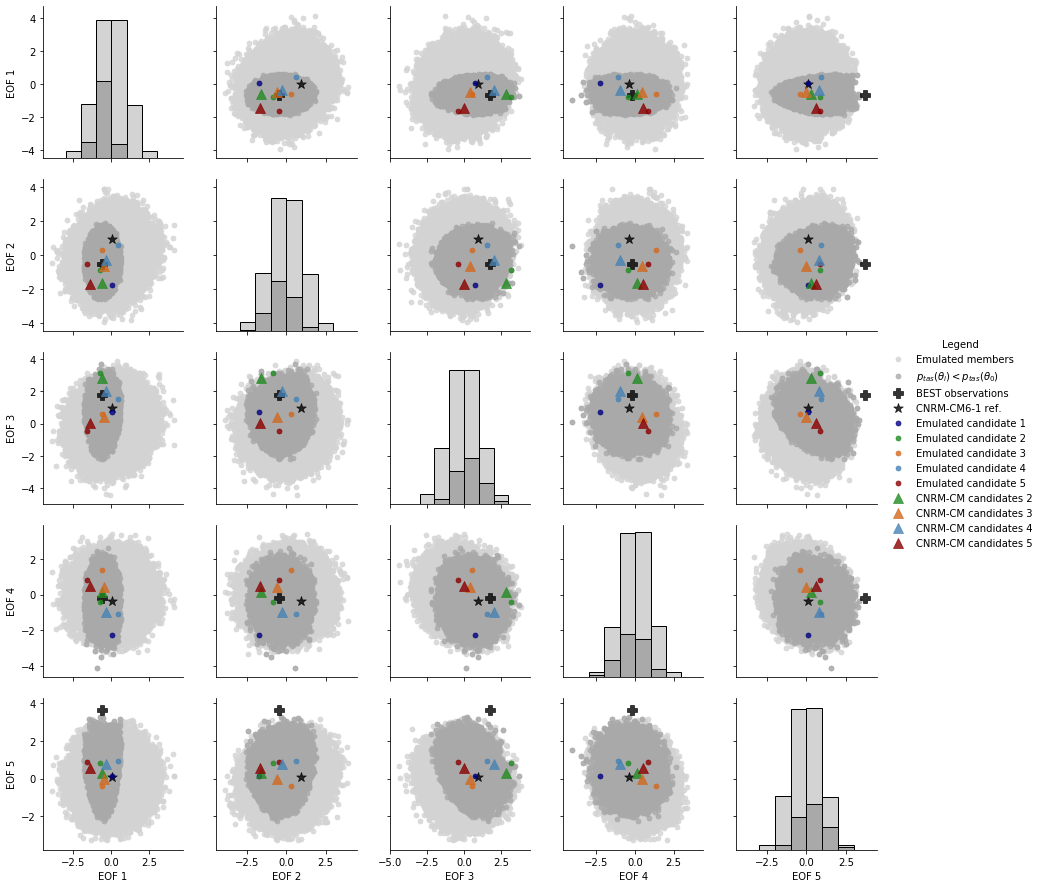

In [101]:
plt.figure(figsize=(15, 15))
    
variables = ['EOF 1', 'EOF 2', 'EOF 3', 'EOF 4', 'EOF 5']
p = ['lightgray',  'darkgray','black', 'black', 
     'navy', 'forestgreen', 'chocolate', 'steelblue', 'darkred', 
     'forestgreen', 'chocolate', 'steelblue', 'darkred' ]
m = ['.','.', 'P','*', 
     '.', '.', '.', '.', '.',
     '^', '^', '^', '^']
n = [-4,-3,-2,-1,0,1,2,3,4]

sns.pairplot(df_fig, vars=variables, hue="Legend", diag_kind='hist', 
             palette=p, 
             markers=m,
             plot_kws=dict(edgecolor=None , s=100, alpha=0.8), 
             diag_kws=dict(edgecolor='black', bins=n))

# Save figure ---------------
name_fig='Candidates_tas_EOF.png'
plt.savefig("/data/home/globc/peatier/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#----------------------------



plt.show()

# Spatial maps CNRM-CM candidates

In [44]:
def diff_3D_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = mod - obs
    
    return diff
    

In [45]:
e_diff=[]
p_diff=[]
u_diff=[]
cpt=0
for X_sel in amip_select : 
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
    X_sel['lat'] = eofs_combined['lat']
    X_sel['lon'] = eofs_combined['lon']
    
    ## -- 3D full error [obs - mod]
    e_diff_tmp = (obs[variable_obs] - X_sel)
    e_diff.append(e_diff_tmp)
    
     ## -- Project the candidates :
    X_sel_w = (X_sel - Mean)*W_eof_2D
    U_sel = solver.projectField(X_sel_w, neofs=18, weighted=False, eofscaling=1)
    
    ## --Reconstruct the candidates :
    X_sel_rec = reconstruct_X(eofs_combined[:,:,:], pc=U_sel[:], nb_dims=2)
    
    ## -- 3D p error [X_obs_rec - X_mod_rec]
    p_diff_tmp = diff_3D_rec(X_sel_rec, X_obs_rec, Mean, W_rmse_2D)
    p_diff.append(p_diff_tmp)
    
    ## -- 3D u error [e - p]
    u_diff_tmp = (e_diff_tmp - p_diff_tmp)
    u_diff.append(u_diff_tmp)

In [46]:
## -- Compute integrated metrics 
e_sel=[]
for X_sel in amip_select : 
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
    X_sel['lat'] = eofs_combined['lat']
    X_sel['lon'] = eofs_combined['lon']
    
    ## -- Compute RMSE 
    e = RMSE(X_sel, obs[variable_obs], W_rmse_2D)
    e_sel.append(float(e))
df_sel['e'] = e_sel
df_sel

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6     EOF 7  \
0  None -0.600673 -1.628882  2.834429  0.136754  0.308275 -1.767404 -0.205207   
1  None -0.468910 -0.608184  0.432991  0.421981 -0.038227  1.266231 -0.194175   
2  None -0.330980 -0.299073  2.033083 -0.981662  0.784916  0.020647 -0.343419   
3  None -1.429836 -1.664361  0.011280  0.484553  0.580557 -0.464069 -1.001579   

      EOF 8     EOF 9  ...    EOF 12    EOF 13    EOF 14    EOF 15    EOF 16  \
0  0.171683  0.009046  ...  0.363790 -0.200908 -1.772613  1.074404 -1.329525   
1 -0.338823  0.460896  ... -0.165585  1.316583 -0.326901 -0.181695 -0.962893   
2 -0.518185 -0.218918  ...  0.886200 -1.013706 -2.062732  0.103687 -0.218105   
3 -0.906295 -0.143870  ...  0.197991  0.569985 -0.453556  0.601147 -0.268341   

     EOF 17    EOF 18         p                Legend         e  
0 -1.080801  1.869777  1.271452  CNRM-CM candidates 1  1.312485  
1  0.069598 -0.033189  1.333681  CNRM-CM candidates 2  1.337315  
2 -1.398216  0.509774  1.248067  CNRM-CM candidates 3  1.269987  
3 -1.313195  0.305790  1.432909  CNRM-CM candidates 4  1.447296  

[4 rows x 22 columns]

In [47]:
## -- p1 reference CNRM-CM6-1

## -- 3D full error [obs - mod]
e_diff_p1 = (obs[variable_obs] - p1_amip)

## -- Project 
X_p1 = p1_amip - Mean
X_p1_w = X_p1*W_eof_2D
U_p1 = solver.projectField(X_p1_w, neofs=18, weighted=False, eofscaling=1)

## --Reconstruct 
X_p1_rec = reconstruct_X(eofs_combined[:,:,:], pc=U_p1[:], nb_dims=2)

## -- 3D p error [X_obs_rec - X_mod_rec]
p_diff_p1 = diff_3D_rec(X_p1_rec, X_obs_rec, Mean, W_rmse_2D)

## -- 3D u error [e - p]
u_diff_p1 = (e_diff_p1 - p_diff_p1)

## Figure

In [48]:
def plot_map(dataset, var,  palette, xmin, xmax, label, title, name_fig) :
    
    lats = dataset['lat'][:]
    lons = dataset['lon'][:]

    var, lons = add_cyclic_point(var, coord=lons)


    fig = plt.figure(figsize=(10, 5))
    ax=plt.gca()
    ax = plt.axes(projection=ccrs.Robinson())

    plt.contourf(lons, lats, var, 
             transform=ccrs.PlateCarree())

    nb_color = abs(xmin)+abs(xmax)+3
    cmap = plt.get_cmap(palette)  
    
    mm = ax.pcolormesh(lons,\
                   lats,\
                   var,\
                   vmin=xmin,\
                   vmax=xmax, \
                   transform=ccrs.PlateCarree(),\
                   cmap=cmap )

    #m.colorbar()
    cbar = plt.colorbar(mm, orientation='vertical', drawedges=False, extend='both')

    cbar.set_label(label, size = 18, style = 'italic')
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')
    cbar.ax.tick_params(axis='both', which='major', labelsize=15)


    ax.coastlines()

    # Save figure ---------------
    plt.savefig("/data/home/globc/peatier/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
    #----------------------------

    plt.show()

## Reference p1

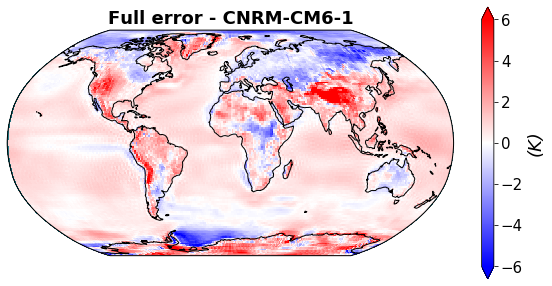

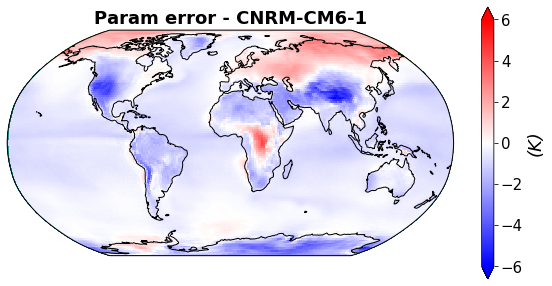

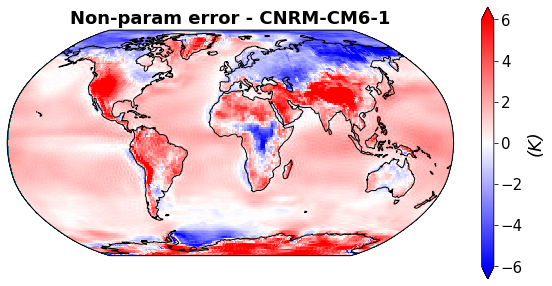

In [49]:
## -- full error e_p1 
dataset = e_diff_p1
var = dataset[:]
palette = "bwr"
xmin = -6
xmax = 6
label = '(K)'
title = 'Full error - CNRM-CM6-1'
name_fig = 'Fig4_full_error_'+variable+'_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

## -- param error p_p1 
dataset = p_diff_p1
var = dataset[:]
palette = "bwr"
xmin = -6
xmax = 6
label = '(K)'
title = 'Param error - CNRM-CM6-1'
name_fig = 'Fig4_param_error_'+variable+'_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

## -- non-param error u_p1 
dataset = u_diff_p1
var = dataset[:]
palette = "bwr"
xmin = -6
xmax = 6
label = '(K)'
title = 'Non-param error - CNRM-CM6-1'
name_fig = 'Fig4_non-param_error_'+variable+'_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

## CNRM-CM candidates 

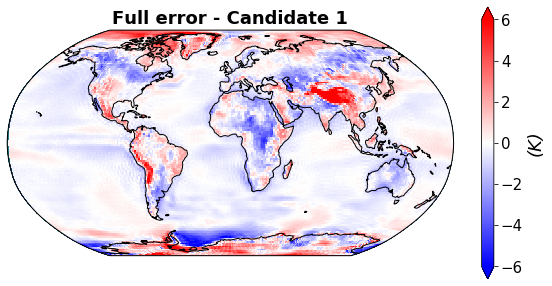

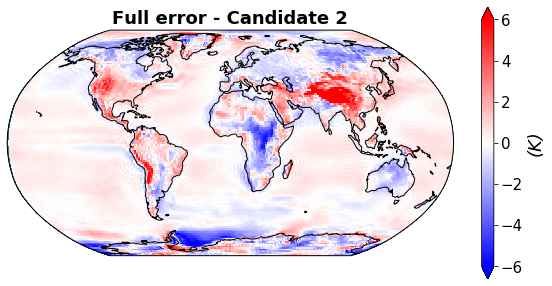

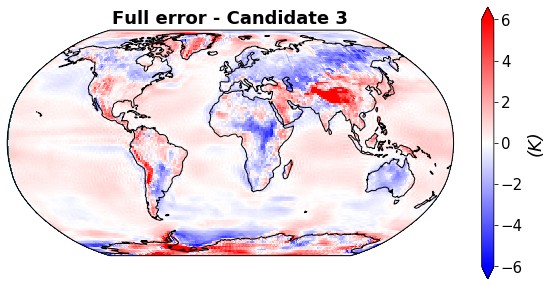

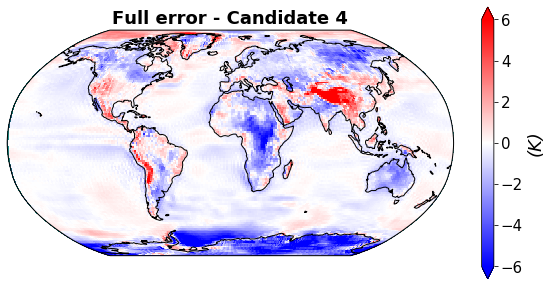

In [50]:
for i in range(0,4,1) :
    dataset = e_diff[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -6
    xmax = 6
    label = '(K)'
    title = 'Full error - Candidate '+str(i+1)
    name_fig = 'Fig4_full_error_'+variable+'_candidate'+str(i+1)+'.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

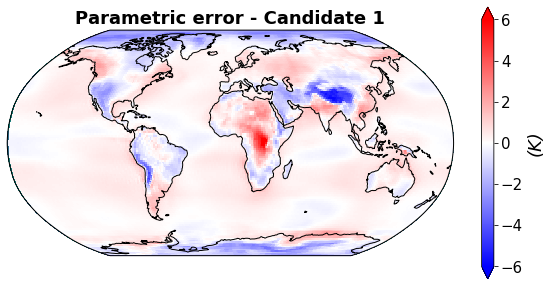

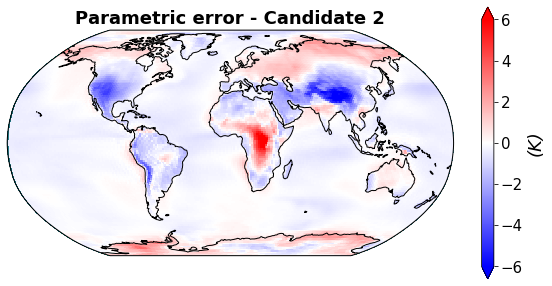

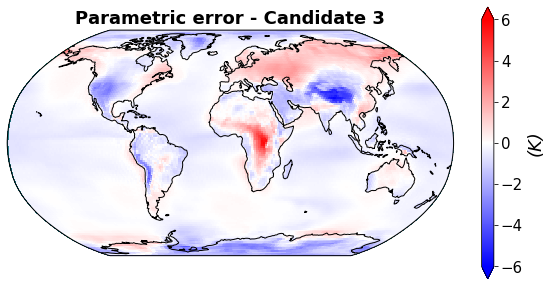

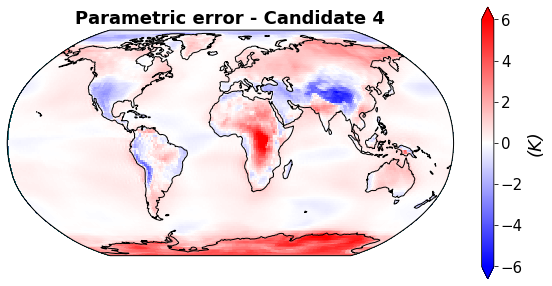

In [51]:
for i in range(0,4,1) :
    dataset = p_diff[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -6
    xmax = 6
    label = '(K)'
    title = 'Parametric error - Candidate '+str(i+1)
    name_fig = 'Fig4_param_error_'+variable+'_candidate'+str(i+1)+'_q18.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

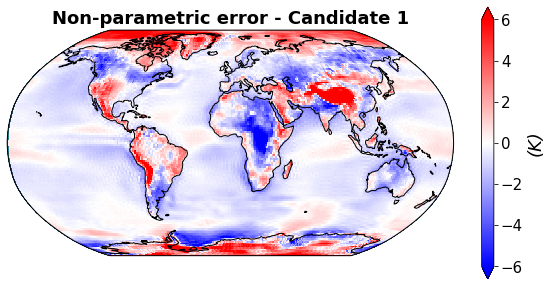

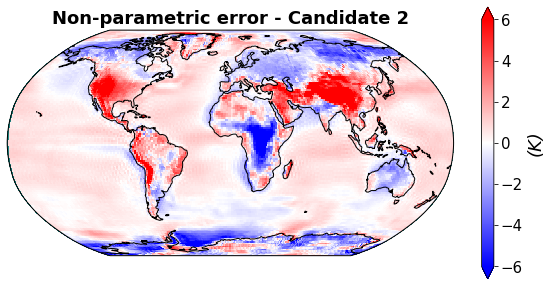

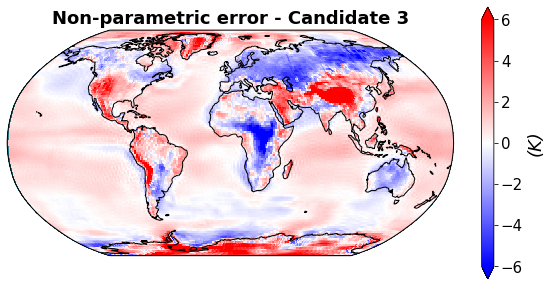

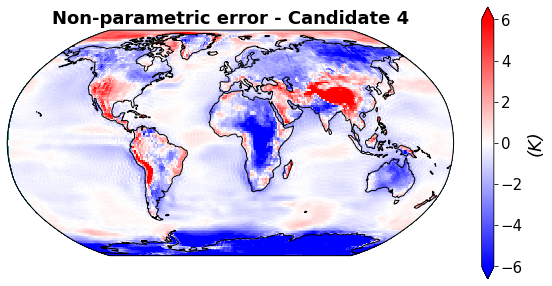

In [52]:
for i in range(0,4,1) :
    dataset = u_diff[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -6
    xmax = 6
    label = '(K)'
    title = 'Non-parametric error - Candidate '+str(i+1)
    name_fig = 'Fig4_non-param_error_'+variable+'_candidate'+str(i+1)+'_q18.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

# Emulated candidates 

In [53]:
df_cand = np.load(path_files+'npy/Candidates_tas.npy', allow_pickle=True)

## -- Param. error 
p_diff_sel = []
for i in range(1,5,1) :
    U = df_cand.iloc[i][1:19].astype('float')
    
    ## --Reconstruct 
    X_sel_rec = reconstruct_X(eofs_combined[:,:,:], pc=U, nb_dims=2)
        
    ## -- 3D p error [X_obs_rec - X_mod_rec]
    p_diff = diff_3D_rec(X_sel_rec, X_obs_rec, Mean, W_rmse_2D)
    p_diff_sel.append(p_diff)

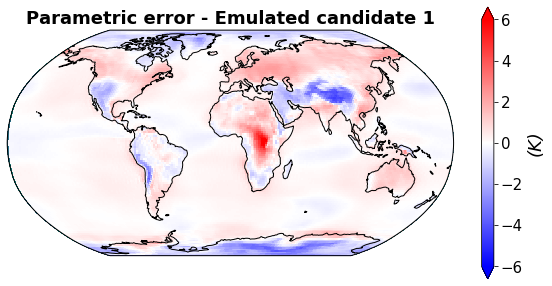

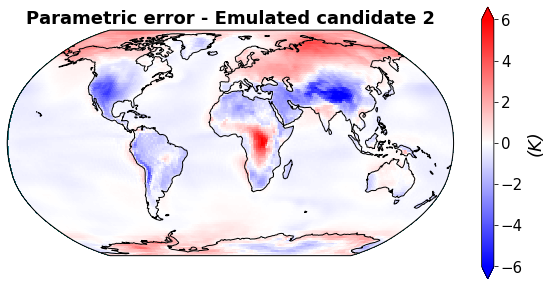

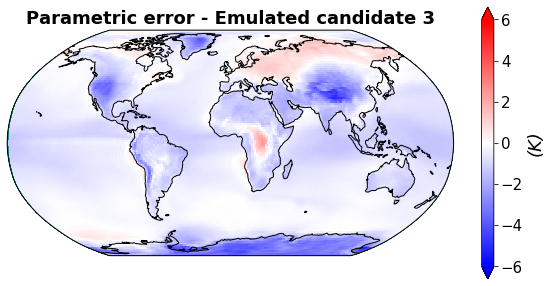

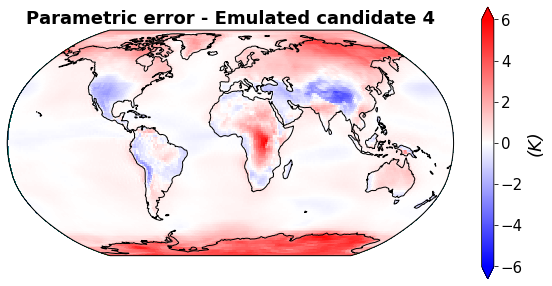

In [54]:
for i in range(0,4,1) :
    dataset = p_diff_sel[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -6
    xmax = 6
    label = '(K)'
    title = 'Parametric error - Emulated candidate '+str(i+1)
    name_fig = 'Fig4_param_error_'+variable+'_emul_candidate'+str(i+1)+'_q18.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

In [55]:
sqrt(8)

2.8284271247461903

In [56]:
sqrt(4)+sqrt(4)

4.0